In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import time
import itertools
# %matplotlib notebook
%matplotlib inline

In [2]:
def roulette_selection(current_population, current_sigmas, objective_values, population_size, children_size):
    fitness_values = objective_values.max() - objective_values
    
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size
    
    parent_indices = np.random.choice(population_size, children_size, True, fitness_values).astype(np.int64)
    
    return current_population[parent_indices, :].copy(), current_sigmas[parent_indices, :].copy()

In [3]:
def mi_plus_lambda(current_population, children_population, current_sigmas, children_sigmas,
                              objective_values, children_objective_values, population_size):
    objective_values = np.hstack([objective_values, children_objective_values])
    current_population = np.vstack([current_population, children_population])
    current_sigmas = np.vstack([current_sigmas, children_sigmas])

    I = np.argsort(objective_values)
    current_population = current_population[I[:population_size], :]
    current_sigmas = current_sigmas[I[:population_size], :]
    objective_values = objective_values[I[:population_size]]
    
    return current_population, current_sigmas, objective_values

In [4]:
def lambda_replacement(current_population, children_population, current_sigmas, children_sigmas,
                              objective_values, children_objective_values, population_size):
    I = np.argsort(children_objective_values)
    current_population = children_population[I[:population_size], :]
    current_sigmas = children_sigmas[I[:population_size], :]
    objective_values = children_objective_values[I[:population_size]]
    
    return current_population, current_sigmas, objective_values

In [5]:
def ES(objective_function=lambda x: (x ** 2).sum(axis=0), d=10, population_size=400, children_size=400, K=0.5, 
       radius=(0, 1), number_of_iterations=100, parent_selection=roulette_selection, replacement=mi_plus_lambda):
    
    tau = K/np.sqrt(2*d)
    tau0 = K/np.sqrt(2*np.sqrt(d))
    
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, d))
    hist_of_best_objectives = np.zeros(number_of_iterations)
    
    current_population = np.zeros((population_size, d), dtype=np.float64)
    current_sigmas = np.zeros((population_size, d), dtype=np.float64)
    objective_values = np.zeros(population_size)
    
# set starting random population and sigmas
    current_population = np.random.uniform(low=radius[0], high=radius[1], size=(population_size, d))
#     print("\nx:", current_population)
    current_sigmas = np.random.uniform(low=1, high=radius[1] * 3 / 4, size=(population_size, d))
#     print("\nsigmas:", current_sigmas)
    
# evaluating the objective function on the current population
    for i in range(population_size):
        objective_values[i] = objective_function(current_population[i, :])
#     print("\nvalues:", objective_values)
    
    for t in range(number_of_iterations):
# parent selection
        children_population, children_sigmas = parent_selection(current_population, current_sigmas, 
                                                                objective_values, population_size, children_size)
        
# mutating children
        for i in range(children_size):
            epsilon0 = np.random.normal(loc=0.0, scale=tau0)
            children_sigmas[i, :] = children_sigmas[i, :] * np.exp(np.random.normal(loc=0.0, scale=tau, size=d) + epsilon0)
            children_population[i, :] = children_population[i, :] + np.random.normal(loc=0.0, scale=children_sigmas[i])
        
        np.clip(children_population, radius[0], radius[1], out=children_population)
        
# evaluating the objective function on the children
        children_objective_values = np.zeros(children_size)
        for i in range(children_size):
            children_objective_values[i] = objective_function(children_population[i, :])
        
# replacing the current population by given replacement
        current_population, current_sigmas, objective_values = replacement(current_population, children_population, 
                    current_sigmas, children_sigmas, objective_values, children_objective_values, population_size)
        
# recording some statistics
        hist_of_best_objectives[t] = objective_values[0]
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
    return best_chromosome, hist_of_best_objectives

# functions

In [6]:
def sphere(X):
#     The global minima: x* =  (0, …, 0), f(x*) = 0.
        return np.sum(X**2)

In [7]:
def schwefel(X):
#     The global minima: x* =  (1, …, 1), f(x*) = 0.
#     return 418.9829*X.shape[-1] - X.reshape(1, -1) @ np.sin(np.sqrt(np.abs(X))).reshape(-1, 1)
    return 418.9829*X.shape[-1] - np.sum(X * np.sin(np.sqrt(np.abs(X)))) 

In [8]:
def rastrigin(X):
#     The global minima: x* =  (0, …, 0), f(x*) = 0.
    return 10*X.shape[-1] + np.sum(X**2 - 10 * np.cos(2*np.pi * X))

In [9]:
def rosenbrock(X):
#     The global minima: x* =  (1, …, 1), f(x*) = 0.
    return sum(100.0*(X[1:] - X[:-1]**2.0)**2.0 + (1 - X[:-1])**2.0)

In [10]:
def griewank(X):
#    The global minima: x* =  (0, …, 0), f(x*) = 0. 
    return (1 + (X ** 2).sum(axis=0) / 4000 - np.prod(np.cos(X / np.sqrt(np.arange(1, X.shape[-1] + 1))),axis=0))

# tests

# Sphere

In [186]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=sphere, 
    d=100, 
    population_size=500, 
    children_size=1000, 
    K=0.5, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 0.026166096970155074


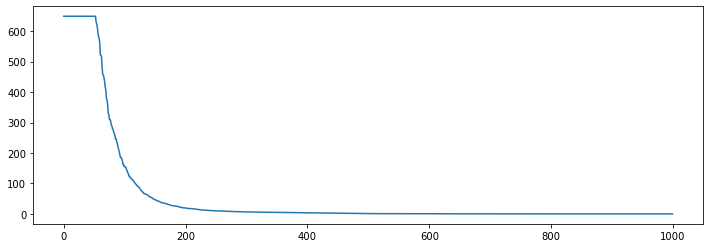

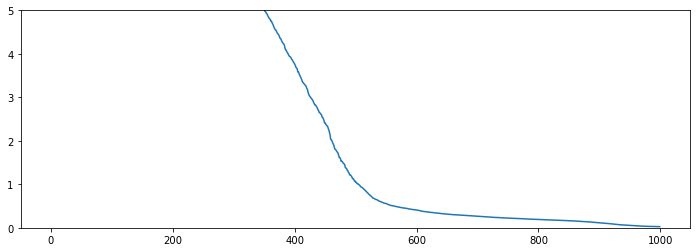

In [190]:
print("Minimum value found:", sphere(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 5)
plt.show()

In [191]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=sphere, 
    d=100, 
    population_size=200, 
    children_size=400, 
    K=0.5, 
    radius=(-5.12, 5.12), 
    number_of_iterations=4000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 0.00486279796309248 [ 2.85807430e-04  8.22834382e-04  2.90920096e-05 -1.34953152e-03
  4.11992754e-04  1.85704772e-04  2.11196764e-02 -1.20298505e-03
  9.23019735e-04 -3.22908034e-04  7.05364939e-04 -2.62593502e-04
  2.17616780e-04 -2.00876046e-04  8.90890427e-05  1.42712962e-03
  3.39422210e-04  1.18934574e-04 -1.86555227e-02  2.61834289e-03
  8.72848510e-04 -4.43059745e-04 -1.81811436e-03 -1.07285097e-04
 -1.45644397e-04  1.99948144e-04  8.02324051e-04 -4.80165527e-04
  4.89019982e-04 -1.80873058e-03  1.09864370e-03  5.30390285e-04
  4.22969458e-04  3.19908656e-04 -5.40824879e-04  3.59296137e-04
 -1.05183265e-04  3.14735490e-03  2.39122023e-04 -2.74899985e-05
 -5.06045151e-05 -4.44314568e-04  6.50631282e-05  5.50816389e-04
  3.33299662e-04 -8.30572080e-04 -8.40946271e-04 -5.65482644e-04
 -1.08383968e-04  3.59849239e-04  1.22831919e-03 -4.05824580e-04
  6.73929570e-04 -4.51979281e-05 -4.45158196e-04 -2.88243617e-04
  9.75613571e-05 -1.42340331e-03 -4.19189429e-04 

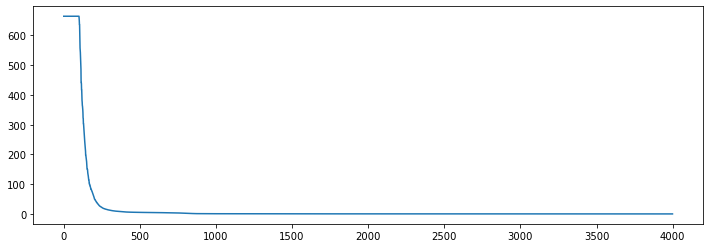

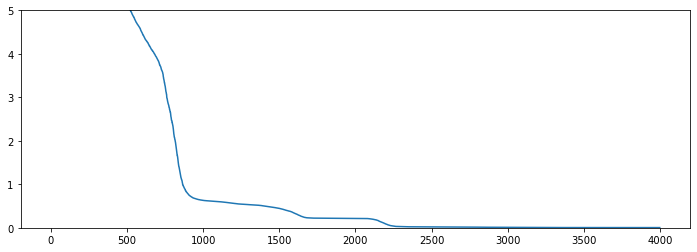

In [193]:
print("Minimum value found:", sphere(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 5)
plt.show()

In [197]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=sphere, 
    d=100, 
    population_size=200, 
    children_size=400, 
    K=0.4, 
    radius=(-5.12, 5.12), 
    number_of_iterations=4000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 2.5742930720755675e-06


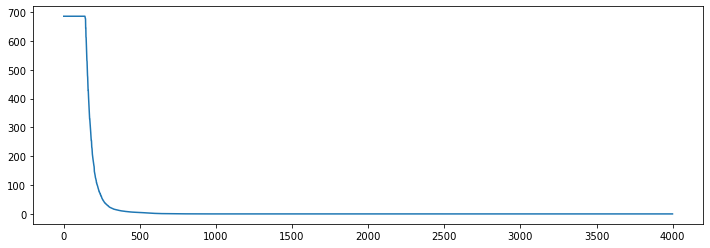

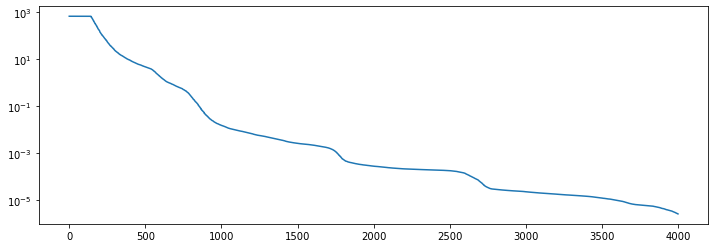

In [199]:
print("Minimum value found:", sphere(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

# Schwefel

In [83]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.6, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 15935.575048673127 [-500.          421.49185603  421.61158153  203.63579582 -121.96372377
  211.45519974 -500.          203.27546985 -124.51039928 -302.26322532
 -301.95037083  -25.9157946  -302.29677377  421.41141235 -302.78464539
 -303.24221719  421.28008143 -302.50681845 -301.27476976  421.99626367
  204.33290731 -341.58915432  203.23997668  421.40472565  -25.72232864
 -272.91520374  204.48465282 -500.          202.64882999 -302.42356659
  203.90060977  420.47471169 -500.          411.96820852 -331.86008266
  421.60579269   63.09368298  421.39098195  421.94130483 -499.99477364
  422.2788057   420.92072222 -134.58198072  421.30779347  421.42318612
  421.06116863 -279.39106965 -123.84961085    4.92052047 -125.12838113
 -301.71324159 -124.89047877  203.44651038 -302.90417852 -302.80581691
  417.81852346  141.44077968  204.15933129 -303.57158261  421.32667104
 -302.96046883  434.71321439  421.32212935 -500.          203.73999925
  418.35106686  420.40799974  420.078

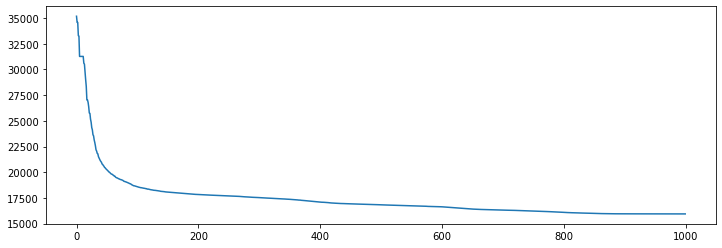

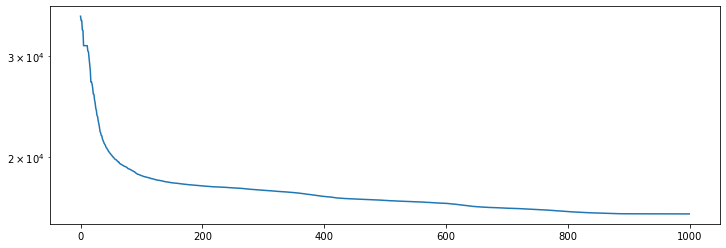

In [84]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [21]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.4, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: [[16284.29811247]] [ 204.34462272  418.75172577  421.35398697  203.45003022  202.89493847
 -303.06754205   64.94600698  -24.78324854  421.12888459  420.62803928
  414.35152005 -301.98047129 -302.24264614  421.02295019 -302.70988593
 -124.26997773 -302.41304685 -302.83595317 -302.4645328   421.78220592
   65.89020553  420.9720082  -302.23557927  204.30445203 -124.8376284
 -125.71956968  204.0688178    65.57514692  203.28931463  421.70648628
 -302.60411429  419.69811817  204.79656885 -303.34589833  204.02038315
 -302.648149   -125.35682085 -302.54541958  421.06368933 -295.76876644
 -121.86822355  203.88259729 -124.74470438 -500.         -130.91166122
  420.94385857  421.42906825   66.60504924 -499.99857987   65.18236065
 -124.68492713 -303.40352053  421.52444891 -302.15030568   66.27059644
  204.33419911 -500.         -301.0539601   193.82155376  421.22099835
  420.71004127  204.00025673 -302.06944575 -124.74180052  204.7084766
 -303.17382475  203.37244235 -303.69739

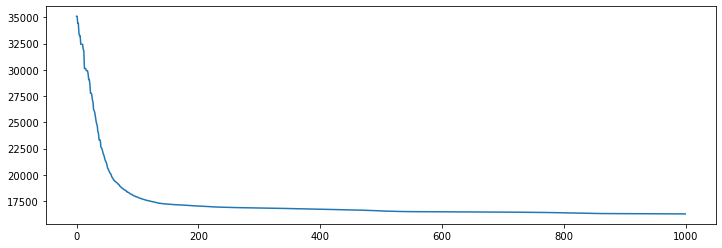

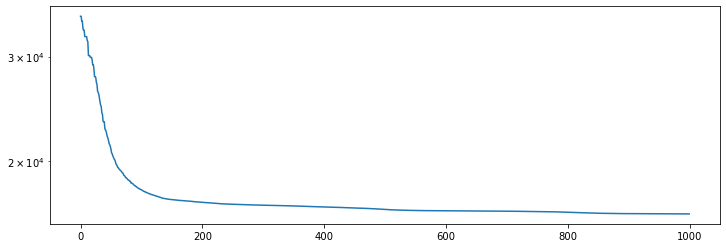

In [22]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [24]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.4, 
    radius=(-500, 500), 
    number_of_iterations=500, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: [[14485.1281919]] [-500.          419.27403896  204.34667957 -302.78377331    4.59004329
 -303.76449252  421.22301577  420.54545167 -499.9958924   421.62005181
 -303.09718634  421.90620926  428.3510534   433.94609401 -301.43813382
  205.00147879 -295.39658121  421.08383503   66.58242719 -303.2316423
  203.01364883  207.85425722  421.00511118  422.87845194  423.09240784
 -303.95665252   69.45305492  421.71366004  204.80663599 -302.32162104
  -26.7765624   417.9828654   421.07591714  203.41609252  205.81788569
 -125.32539655  203.90454191 -125.497355    422.03566778  204.35547528
  420.56455638 -303.34505725  421.85400738  428.75433785  196.40894667
  421.52156112 -297.98176305  420.71222736  198.39639461  425.24411723
  425.98068386 -276.33530168  -56.57459154  205.10470633  420.18364402
  203.96527579  422.0477319   421.68239066 -303.18017453 -303.3777209
  -27.41816219  421.76605586  203.48403347 -500.         -304.10326143
 -303.09077404 -124.11866399 -302.743871

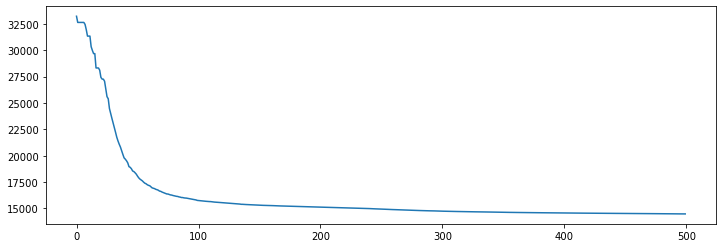

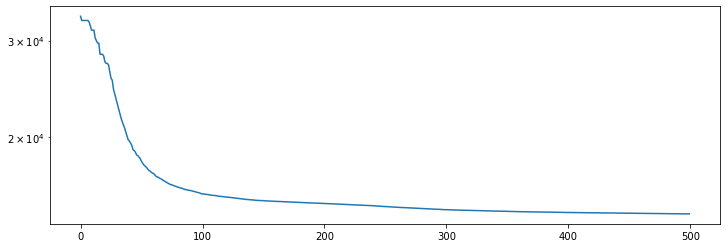

In [25]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [26]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=500,
    children_size=8000, 
    K=0.3, 
    radius=(-500, 500), 
    number_of_iterations=500, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: [[13669.08424061]] [-302.88432348 -300.99336494 -500.          420.50852069  419.86938079
  419.13971363 -499.35919636  421.51469274 -125.72631823   14.66255649
 -500.         -302.82497598 -301.26001834 -304.05227048 -322.29323282
 -303.3194806   -25.2963581  -303.04307818 -303.38884359 -325.34901358
 -298.73826217    5.22197925  421.59627564 -123.38792731  420.07467436
 -304.40444514  420.05452724 -124.48349546 -303.51764371  420.82663482
 -500.         -124.65420287 -302.66946339  426.84428101 -125.4768052
  420.93357428  422.71042353  419.14282328  422.17061243 -303.93979928
 -303.44091312   88.28503882 -303.29111505 -302.25661088  420.24815575
  421.87894925  420.14867328  421.30943201 -303.29720465  421.13195179
  203.33425758 -123.77526964  205.57418789 -124.47161796  421.85297491
  203.89066819  420.52462987   63.94008782  204.06507226 -300.77110218
  421.77194865 -301.80605993 -302.58858295 -500.          420.98388321
 -303.56349083 -301.75571214 -124.8490

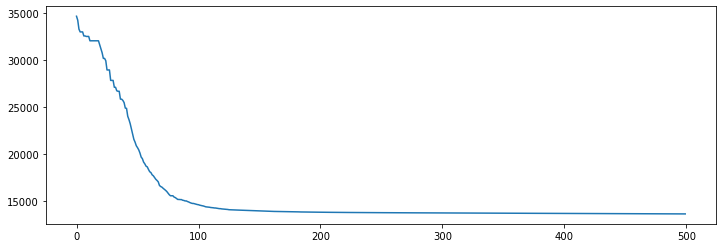

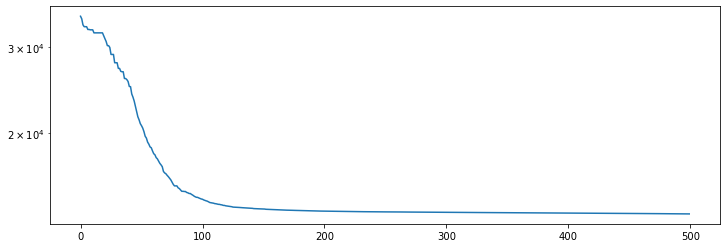

In [27]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [29]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=8000, 
    K=0.3, 
    radius=(-500, 500), 
    number_of_iterations=500, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: [[15913.60956519]] [ 204.04974647  420.87685541 -500.          408.84867273  412.89546862
 -302.83444287  435.7269233    65.67070476  421.21772449  -26.15138263
 -500.         -500.         -311.80075641  419.3834518  -302.70253453
 -500.         -302.01057112 -303.46688094 -124.64051704 -308.60056902
 -302.24992833  418.75228238    5.28941893  421.86041229 -302.43196678
  419.83727798 -302.71379065 -302.92054232  189.95046219  421.15738562
 -302.68678137  420.18946564 -303.26577883 -302.11229262  402.76560546
  413.75357057   66.11916799   67.48344044 -303.32137637 -302.27003311
  204.34805779  203.74353932 -302.13812958  421.00547779  420.35450349
 -300.4957213     4.54931267 -500.         -125.0967892   421.27955597
 -303.37880639  203.41508627  422.00771743 -302.26642419  104.54040468
 -303.45839533  203.71937989  416.02544676 -130.24620366  421.62100137
  419.04982682  421.52343419 -500.         -125.42479179  203.27806834
  420.7346506  -125.02082426  421.351

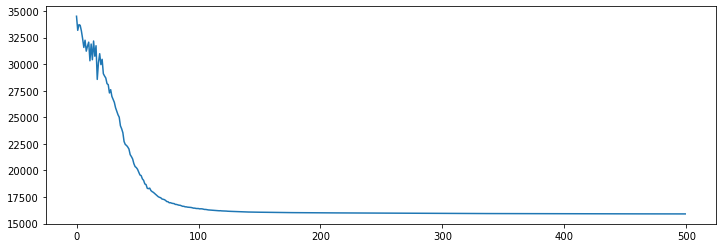

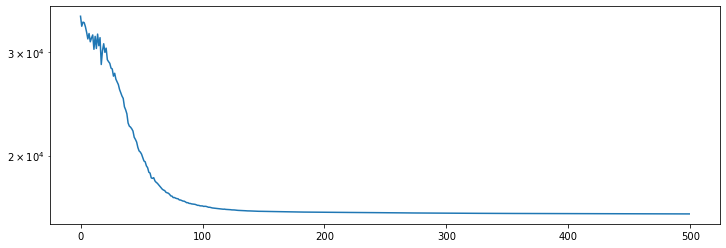

In [30]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [32]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=100, 
    children_size=10000, 
    K=0.3, 
    radius=(-500, 500), 
    number_of_iterations=500, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: [[15377.82882313]] [ 421.2114939  -303.26831863  418.26616128  421.59249762  205.13408454
   65.26433815 -124.38995921  421.24005539 -500.          421.62015016
  415.11670703 -296.37022853 -303.83851456  427.1293402  -301.9601486
  204.28557162  420.91331329 -125.15808552  416.59224185  204.29222474
 -302.22953883  203.50019259 -120.31595064  420.68182377 -302.63479833
  202.98448366 -124.15610704  421.8907001   203.00859026 -500.
 -303.17825392 -302.34341811 -124.76388094 -124.14951393   65.06354326
 -302.04249184 -126.43826372   63.77026118  420.48080037  164.57530308
 -302.5243995   201.74779814 -124.98010189 -302.41243475 -302.89648979
 -500.         -302.47127934 -302.23600087   64.98676745 -303.4008242
  420.80230379  -23.46420527  427.12886787  421.3130876    66.1486031
 -302.74309502  -25.72055504  419.90797102 -124.91300677  420.91625651
   18.25422561 -301.64181732  204.48647695  421.38464098 -301.1068362
 -301.91158499 -500.           65.79899379  221.4

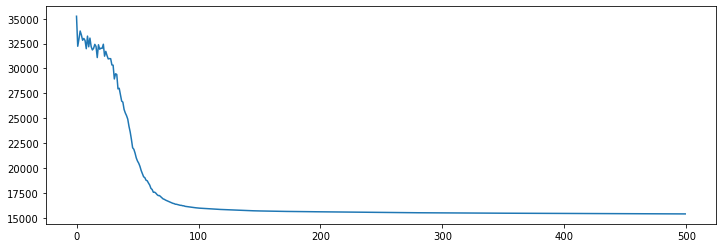

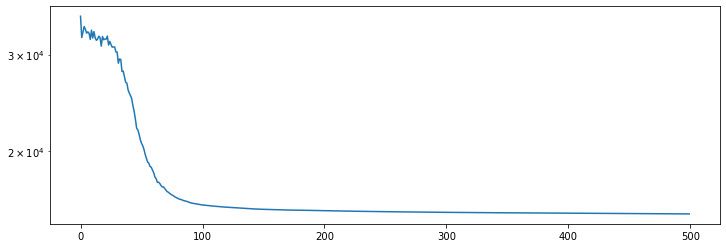

In [33]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [34]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=100, 
    children_size=10000, 
    K=0.3, 
    radius=(-500, 500), 
    number_of_iterations=500, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: [[16651.39045443]] [ 426.61179097   65.73815528 -302.15196237 -169.34274179 -299.82608306
 -305.88913131 -303.27386454  431.35929275 -499.99656323 -255.15009639
  -26.45435903   68.08515312 -499.9939391  -500.         -302.73547263
  420.69251322 -298.72954528 -304.10760522 -302.62272908 -302.99292916
  -25.09239317 -302.22201416 -301.95000956  422.16254721  421.33258659
 -499.99282727 -500.         -500.         -499.99360029  421.56842841
 -302.92399034 -499.99661045 -500.          419.61597738 -302.21571234
  203.62441453  -37.50636661  420.67395045 -125.00475105 -301.8601265
  421.56247901  430.80757311 -125.03122469 -302.35160555 -302.10419307
  416.13924775 -301.79732857 -500.         -301.8584314   455.39031222
  419.36518954  421.64133375 -302.47781506  422.35163627 -500.
  204.52530436  419.40408113  203.23831423 -303.96592726  160.11032898
  -26.23651     418.89814641  433.29043407 -124.012849      6.62070009
 -121.01565756 -302.57073294 -301.8565698  -16

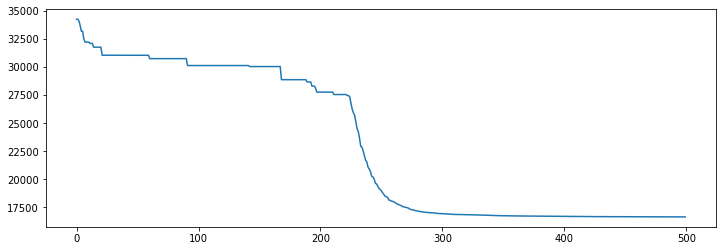

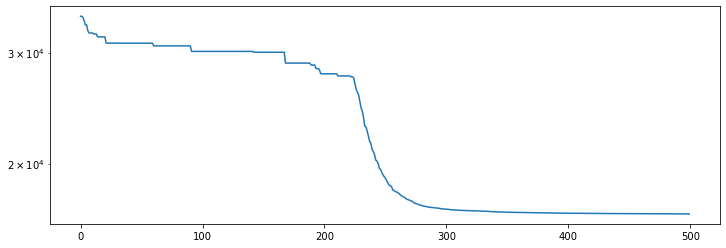

In [35]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [80]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=schwefel, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.20, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: [[13975.19168969]] [ 420.93973023  202.30667318  420.39146448   63.06271986  203.92212306
  421.0146011    65.79012974 -302.21311573  203.59765761  421.1530821
  421.28418253 -302.87064135 -302.29803798  421.00555991 -125.05321002
 -125.02435958 -124.68969827  420.8388124  -305.7842799  -303.09316517
    8.51412069 -500.          420.91856029 -124.06049302  420.77270968
  421.11838109  203.85703441   65.18642497  203.69214161  -26.51966597
  420.72637077  407.83532781  203.74406278   65.70488818 -302.48181131
   66.13423976  421.29590432   65.77709172  204.10429553  212.00176468
 -124.97184887 -303.01670949  420.45551925  -25.82727912 -124.49966747
  416.39362895 -124.62125924  420.57524497  -25.9903416  -124.64661804
 -124.76780575  420.89818548  420.63104309  420.99828468  418.53965823
  421.41416304  421.0144385   203.64308556  204.24056799 -302.978514
  199.69051419  420.7542784  -303.01125878  420.72764876  420.99447563
 -302.14356048 -302.04278929 -301.548883

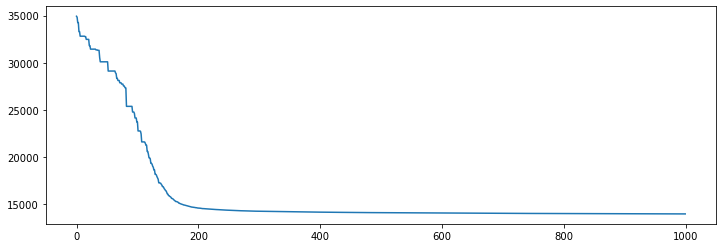

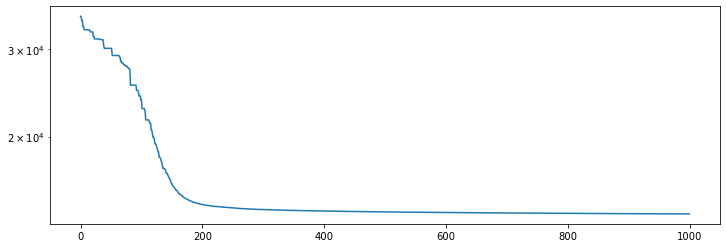

In [81]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

# Rosenbrock

In [ ]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=500, 
    children_size=1000, 
    K=0.5, 
    radius=(-5, 10), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 533.0538072896435


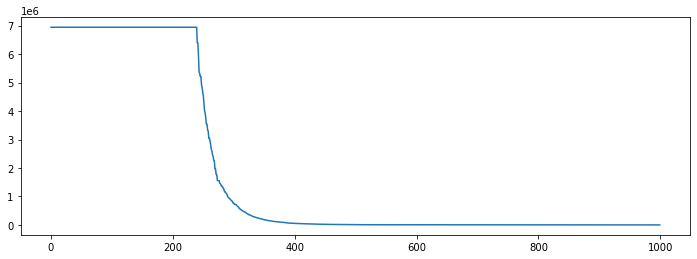

In [167]:
print("Minimum value found:", rosenbrock(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

Minimum value found: 533.0538072896435


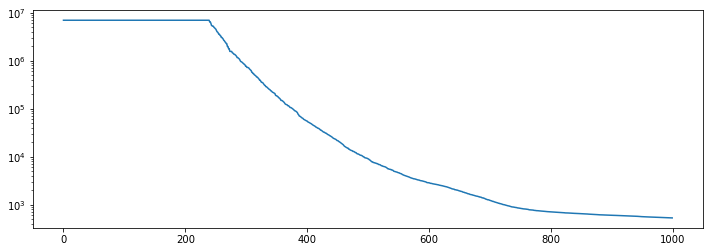

In [168]:
print("Minimum value found:", rosenbrock(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
plt.show()

In [169]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.5, 
    radius=(-5, 10), 
    number_of_iterations=2000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 297.0002031052986


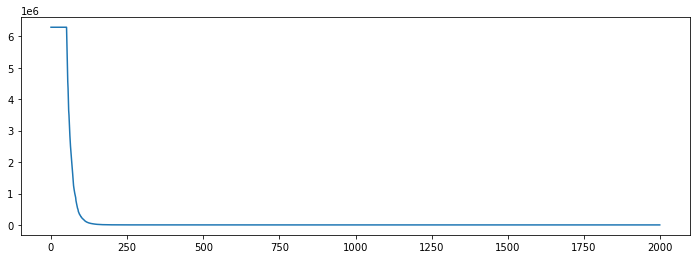

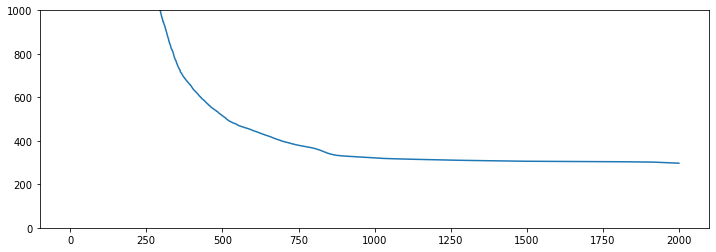

In [181]:
print("Minimum value found:", rosenbrock(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [182]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=400, 
    children_size=2000, 
    K=0.6, 
    radius=(-5, 10), 
    number_of_iterations=2000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 386.9862500459831


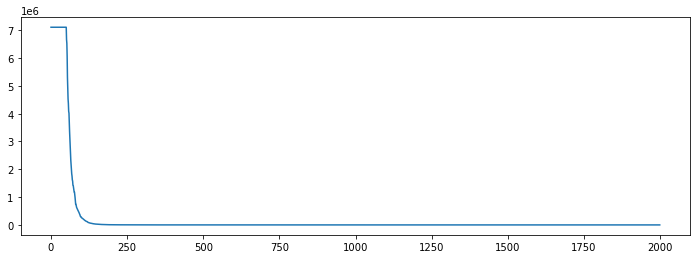

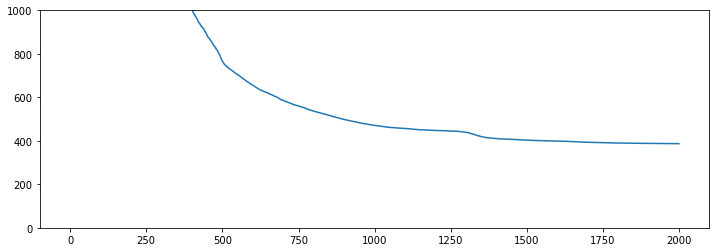

In [183]:
print("Minimum value found:", rosenbrock(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [39]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.5, 
    radius=(-5, 10), 
    number_of_iterations=2000, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: 256.5135235514812


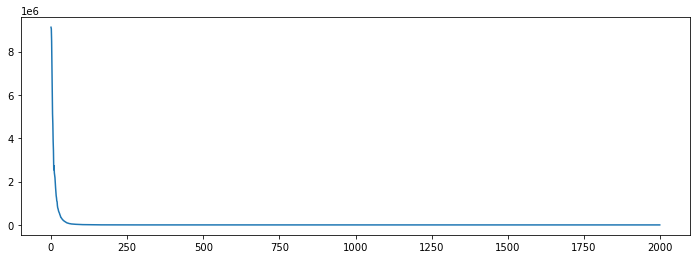

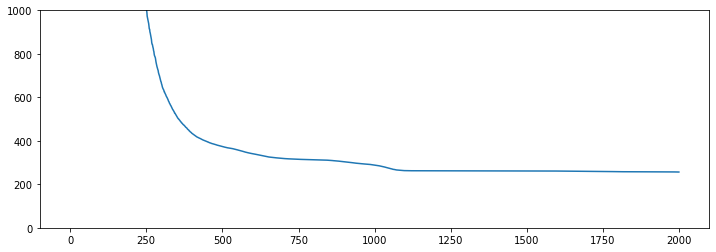

In [40]:
print("Minimum value found:", rosenbrock(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [41]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.4, 
    radius=(-5, 10), 
    number_of_iterations=2000, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: 254.54528360124647 [ 0.9303027   0.86371201  0.74425762  0.54989325  0.29323131  0.05969033
 -0.15676836  0.55486099  0.70929538  0.77561734  0.72749307  0.6122808
  0.43345533  0.20996731  0.05874317  0.01239218  0.01069856  0.0114405
  0.01161198  0.01280806  0.01146542  0.00726542  0.00533739  0.01393261
  0.01075577  0.00857596  0.0060423   0.01236036  0.01286314  0.0083448
  0.01226017  0.00933039  0.01043355  0.01025009  0.00777227  0.03336164
  0.00924033  0.00873504  0.01307789  0.01275103  0.00979044  0.00920799
  0.01514946  0.00816018  0.00784008  0.00374343  0.01054763  0.07011397
  0.45045774  0.69770983  0.83322369  0.90275142  0.92910763  0.92172171
  0.88084559  0.79920237  0.66239678  0.45661307  0.22220565  0.05204302
 -0.03301892  0.01094308  0.00975676  0.01356191  0.01524414  0.00972299
  0.00298283  0.00901968  0.00910468  0.01310164  0.00526328 -0.41491687
  0.6911562   0.84128657  0.90939239  0.93722483  0.93297239  0.89781481
  0.82198492  

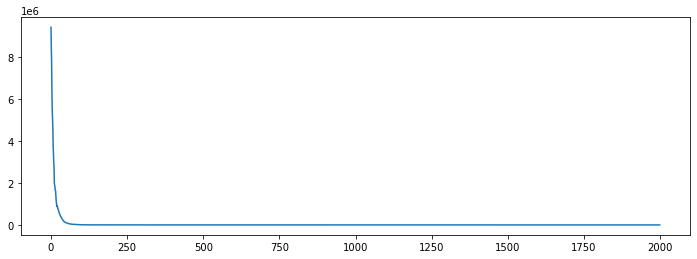

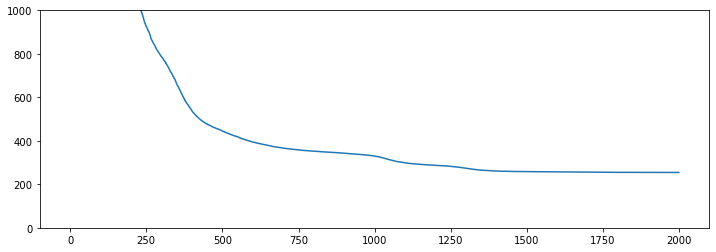

In [43]:
print("Minimum value found:", rosenbrock(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [44]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.35, 
    radius=(-5, 10), 
    number_of_iterations=3000, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: 140.0034795640906 [ 9.98044064e-01  9.95272504e-01  9.89191301e-01  9.79315606e-01
  9.57460793e-01  9.14370878e-01  8.33547141e-01  6.95483219e-01
  4.83260232e-01  2.26564850e-01  1.35391005e-02  8.28081437e-03
  1.02058413e-02  1.13432146e-02  9.16574083e-03  8.07435301e-03
  9.71235547e-03  9.30358055e-03  1.10344788e-02  1.64954300e-02
  1.13997441e-02  9.05402947e-03  1.44162985e-02  1.20430044e-02
  9.78311031e-03  1.32871045e-02  2.20243972e-02  1.16684565e-02
  1.06082212e-02  1.02766379e-02  1.13977421e-02  1.29921874e-02
  9.58299936e-03  1.17675363e-02  9.67028771e-03  1.19398515e-02
  1.04471372e-02  1.06043744e-02  1.35153648e-02  3.36929021e-03
 -4.65677306e-01  7.23706691e-01  8.71423173e-01  9.37503389e-01
  9.68250553e-01  9.83422789e-01  9.88156900e-01  9.89678881e-01
  9.86653679e-01  9.77897275e-01  9.60372126e-01  9.24008415e-01
  8.55238053e-01  7.32619116e-01  5.44593076e-01  3.05458225e-01
  1.01647958e-01  1.46853694e-02  1.34044196e-02  7

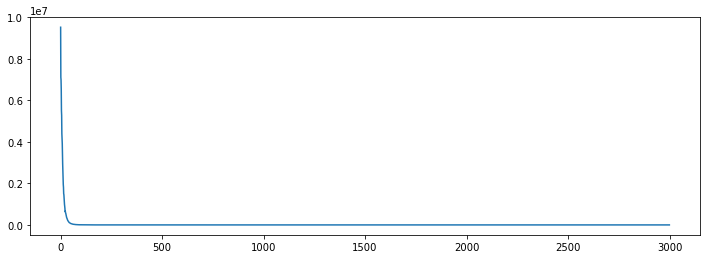

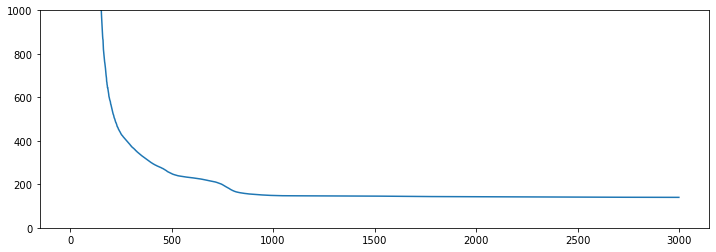

In [45]:
print("Minimum value found:", rosenbrock(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [59]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rosenbrock, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.6, 
    radius=(-5, 10), 
    number_of_iterations=2000, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: 146.41846513553457 [ 0.98255309  0.96821619  0.93898224  0.8840119   0.78330956  0.61211154
  0.39249388  0.16705225  0.03934095  0.01725481  0.01051504  0.01079987
  0.00960361  0.01219518  0.01301815  0.01200909  0.00911104  0.0095492
  0.01537033  0.01014125  0.01141837  0.00667121  0.01003352  0.00836703
  0.00959748  0.00925625  0.00994566  0.00817404  0.00783639  0.00893672
  0.00888788  0.00606339  0.00707232  0.01056533  0.01136739  0.00916967
  0.00910677  0.00986029  0.00847088 -0.01002353  0.01094799  0.00787807
  0.00968071  0.01052883  0.01154222  0.0115497   0.00967632  0.00821075
  0.0132713   0.01045613  0.01097181  0.01088571  0.02784782  0.01058077
  0.01057579  0.01210874  0.01059365  0.01304434  0.00802448 -0.08299323
  0.01699648  0.01085181  0.00508058 -0.37912196  0.65736301  0.81733056
  0.90258853  0.94438051  0.95462807  0.94763402  0.91910675  0.85580106
  0.7405946   0.55919064  0.32119543  0.11229671  0.02402094  0.01072057
  0.01005157

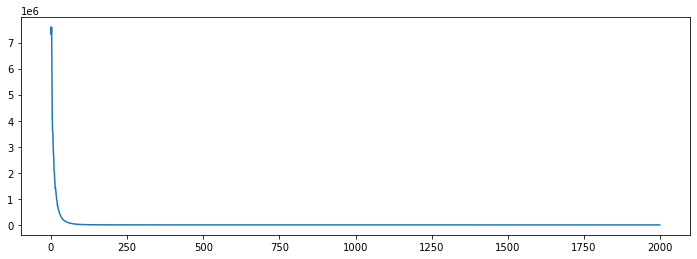

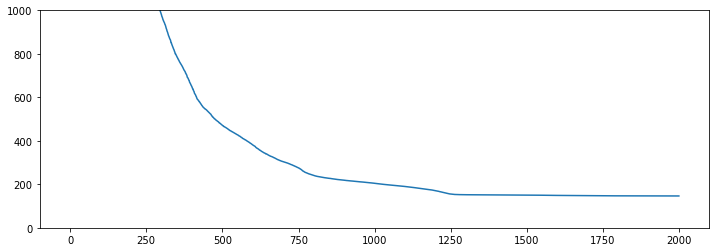

In [60]:
print("Minimum value found:", rosenbrock(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

# Rastrigin

In [50]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.5, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 478.57278256711777


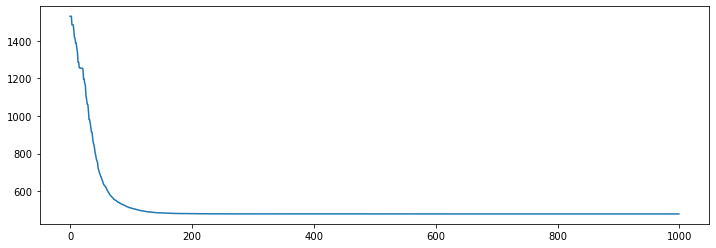

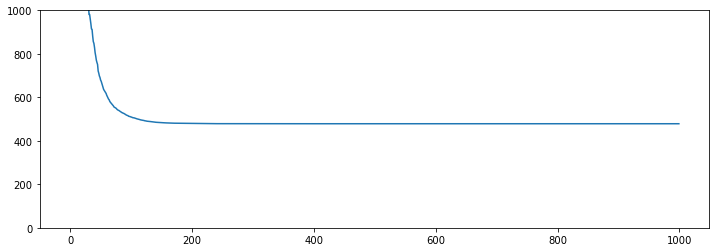

In [54]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [55]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.4, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 407.93143592862714


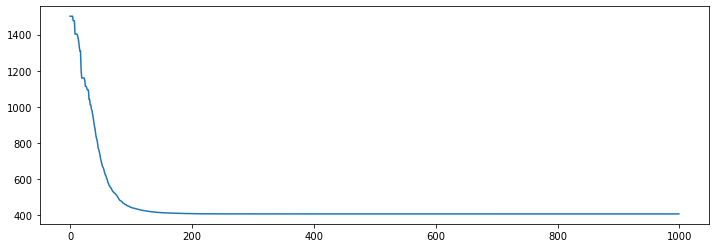

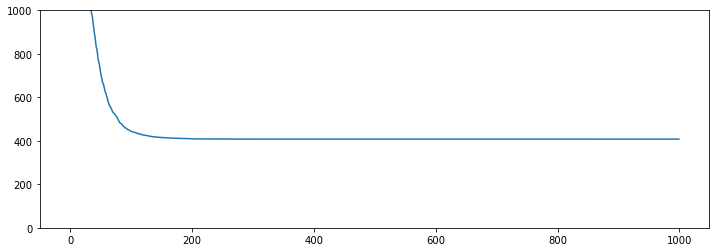

In [56]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [61]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.35, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 335.30001493791224


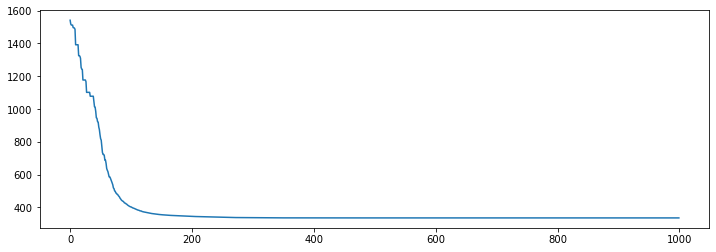

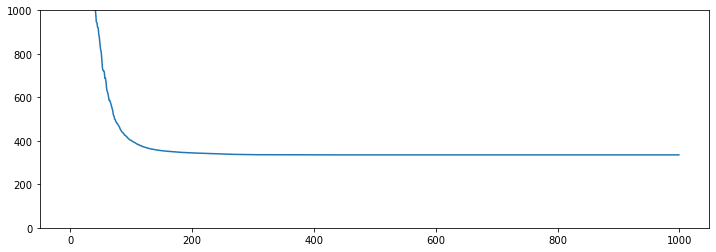

In [62]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [68]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.25, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 247.74404191630526


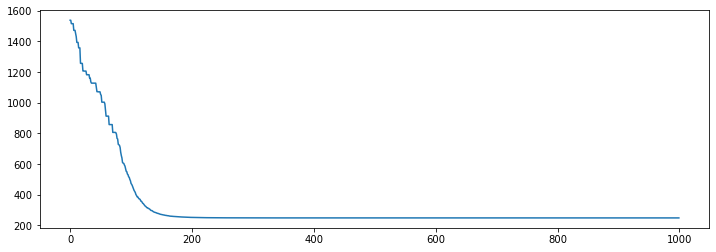

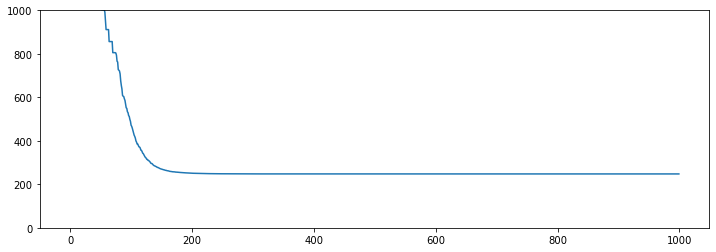

In [71]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [72]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.15, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 262.66824076461205


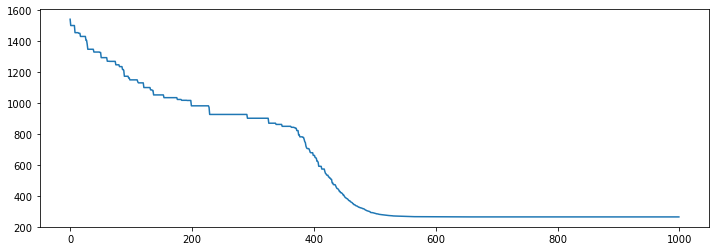

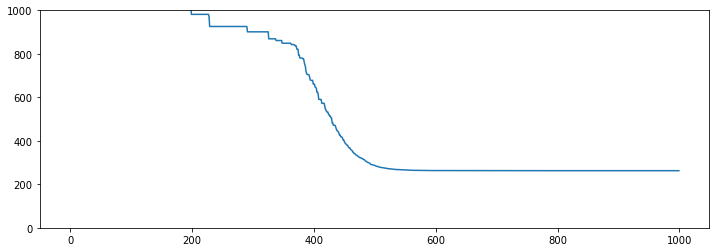

In [73]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [74]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.20, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 213.915793798751 [-9.94958501e-01  1.98991239e+00 -1.78024056e-07  9.94958598e-01
 -3.92732050e-07 -2.98485603e+00  9.94958716e-01 -1.98991201e+00
  1.98991264e+00  1.19887345e-07  1.98991217e+00  1.98991217e+00
  3.06872675e-08 -1.04084032e-07  2.98485568e+00 -8.96579534e-08
  9.94958707e-01  1.98991231e+00 -9.94958616e-01  1.98991240e+00
 -1.94178671e-07  5.81501218e-08 -1.98991191e+00  9.94958880e-01
 -9.94958562e-01  2.43796415e-07 -9.94958966e-01  9.94958471e-01
 -2.98485186e+00  5.12579768e-08  7.64621118e-09 -9.94958655e-01
 -9.94958601e-01  1.98991210e+00  9.94958628e-01 -1.98991246e+00
  9.94958800e-01  9.94958470e-01 -1.72914877e-07  6.41801950e-09
 -2.98485577e+00 -9.94959142e-01 -1.98991246e+00  2.98485519e+00
  9.94958144e-01 -1.41818315e-07 -9.94958608e-01  9.94959004e-01
  9.94958584e-01  1.98991213e+00  9.94958612e-01 -9.94958660e-01
  9.94958824e-01  1.87341857e-07 -1.98991198e+00  9.94958552e-01
  9.94958787e-01 -1.98991223e+00 -9.94958744e-01 -1.

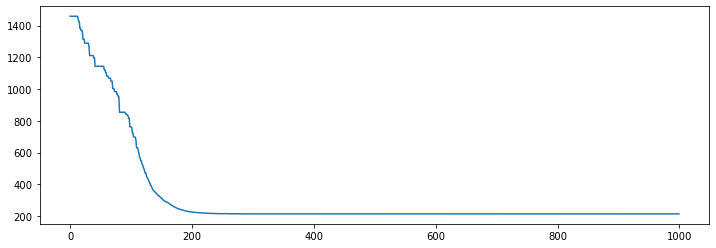

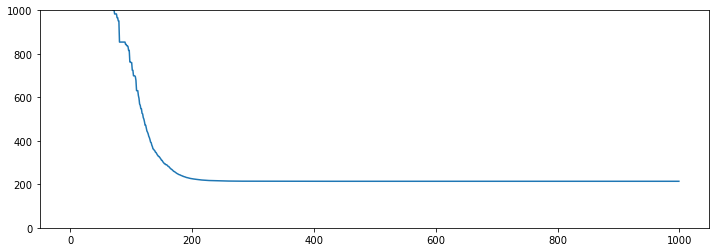

In [77]:
print("Minimum value found:", rastrigin(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [78]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.20, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: 231.82492526216356 [-1.98991263e+00 -4.36936998e-08  9.94959410e-01 -9.94958161e-01
  1.98991197e+00 -9.94958805e-01 -9.94957681e-01  2.98485558e+00
 -1.98991236e+00  1.98991178e+00  1.98991216e+00  1.38584149e-07
 -2.98485700e+00 -2.98485557e+00  2.98485586e+00 -1.98991232e+00
 -1.06979686e-06  4.95845484e-07  9.94958740e-01  2.33676310e-07
 -9.94958448e-01  1.98991310e+00 -9.94958210e-01 -1.98991265e+00
  9.01715001e-08 -9.94955809e-01  1.55052145e-07 -9.94959503e-01
  9.94958371e-01 -2.98485525e+00 -1.46219758e-07 -3.37201037e-07
  1.12127338e-06 -9.94958713e-01  1.98991270e+00 -1.98991204e+00
  9.94958089e-01 -9.94958792e-01 -1.98991218e+00  9.94959151e-01
 -9.94958587e-01 -6.72002167e-07  1.98991304e+00  9.94958089e-01
  7.53989946e-07  9.94959560e-01  9.94958090e-01 -1.61429328e-07
 -9.94958758e-01  3.59174874e-07  9.94958605e-01  9.94957797e-01
 -9.94958301e-01 -1.01854231e-06 -1.98991245e+00 -1.98991149e+00
 -3.97978379e+00  1.19956564e-07  9.94958321e-01 -

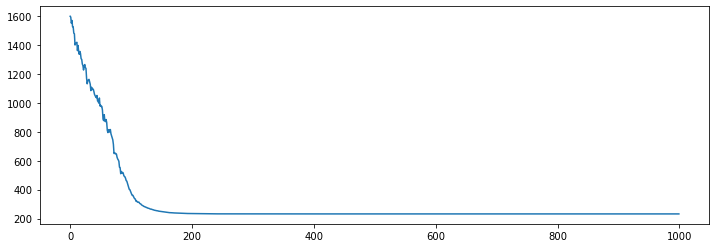

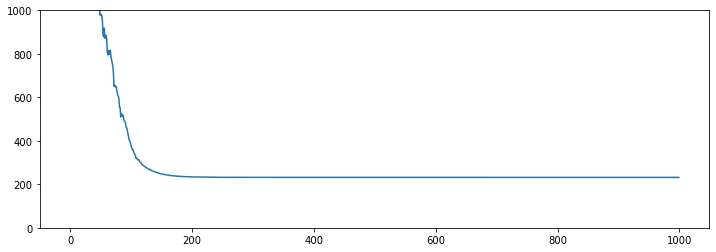

In [79]:
print("Minimum value found:", rastrigin(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

## Griewank

In [97]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=1000, 
    children_size=2000, 
    K=0.5, 
    radius=(-600, 600), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 10.925511039204004 
Best x: [-3.55625662e+00 -1.07469284e+00  1.62515946e+02  1.74332530e+00
 -3.83096215e+00  1.13726704e+00  5.10447175e+00 -2.36886662e+00
  2.91551470e+00 -2.05734516e+01 -6.24324201e+01  7.58378029e+00
  1.86383036e+00  9.36945657e-01 -1.04208330e+00  1.46315357e+00
 -2.57007466e-01 -2.04326676e+01 -3.55486387e+00 -5.99751008e+00
 -4.98512506e-01 -5.35258223e+00 -1.70713171e+01 -4.65314523e+00
 -7.68049407e+00  4.10162672e+00  6.78784637e+00 -5.29739335e+00
  1.22514389e-01  1.64744399e+00  9.12134558e+00  4.95246584e+00
 -3.56910369e+00 -3.56741902e+00 -1.68914381e+00  6.70519596e+00
  3.10960420e+00  2.78876049e+01 -3.13223795e+00 -8.28056231e+00
  5.26836920e+00  2.01257975e+01  1.36056570e+00 -4.34918665e+00
  3.01783631e+00  2.64911052e+00  2.51575615e+01  2.99879414e-01
 -1.10515369e+01  1.68428979e-01 -5.24158854e+01  1.13739653e+00
 -1.40507821e+00  9.79638034e-01 -1.15825115e+00  1.56117283e+00
 -2.71486913e+00 -3.99559345e+00  7.34665

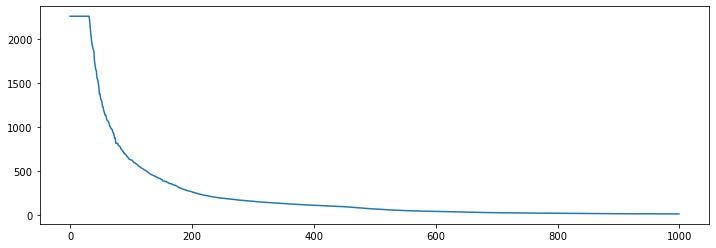

In [98]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [99]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=1000, 
    children_size=2000, 
    K=0.4, 
    radius=(-600, 600), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 152.6308512465359 
Best x: [-2.73436162e+02 -1.66833329e+02 -3.54806820e-01 -1.38878890e+00
  3.80677909e+00  8.55156485e+00 -5.00229654e+00  4.31304402e+00
  1.26209230e+00 -8.80589863e+00 -2.94742406e+01  1.47246924e+01
 -7.98013773e+00 -3.86775148e+00 -2.56292648e+00  2.56228033e-01
 -6.61080610e+01 -2.45623422e+00 -7.73545752e+00 -3.56087852e+01
 -3.58179690e+00 -1.43641204e+00  8.85933835e+00 -5.87446414e+00
 -1.67319018e-01 -1.45485560e+01  2.15798033e+01 -9.04967685e+00
  7.75753933e-01 -5.13076331e+01 -3.38919605e+00 -2.69483554e+00
 -5.28167059e+01  9.85548940e+00 -1.32559346e+01 -3.94038408e+00
  1.23698798e+00  3.58074261e+00 -2.81492162e+00  8.05563057e+00
 -1.33905078e+01  2.41258960e+00  4.73087712e+02  1.89906078e+02
 -6.33357214e+00 -3.94952543e+00 -3.13815727e+00  1.87042761e+00
  1.33877840e+02  6.59101042e+00  1.49261167e+01  8.09540907e+01
 -4.49700489e+00 -6.26644697e+00 -5.00483028e+00 -3.43491210e+00
 -8.31139226e+00 -2.49967793e+00 -2.129784

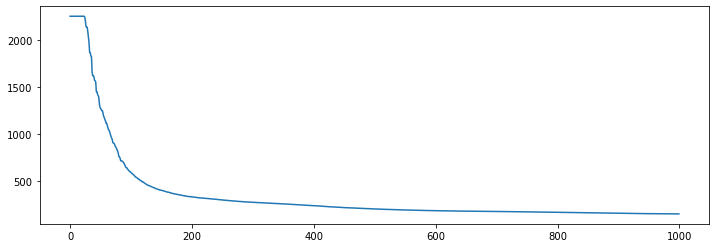

In [100]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [103]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=200, 
    K=0.4, 
    radius=(-600, 600), 
    number_of_iterations=10000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 0.2825804010907408 
Best x: [-3.13881634e+00 -1.67227442e-03  4.84745862e-03 -7.77632568e-03
  8.96554009e-03  2.11959409e-02 -4.34491358e-02 -7.99959037e-03
 -1.22488116e-02  5.05817321e-03  4.86165911e-02  4.40911013e-03
  3.22322442e-02 -2.20470317e-01 -7.33082442e-03  1.14034459e+00
 -3.63764734e-03 -3.12792320e-03  9.92883330e-03 -3.14523584e-01
  5.90398044e-02  3.86844973e-01 -4.41735136e-02  7.17830209e-02
  4.10118642e-02 -8.30598779e-02  3.15481555e-03  1.53926571e-02
  2.05921023e-02  5.45275920e-02  1.20268878e-01  1.73530395e-02
 -1.83233918e-02  2.64584781e-02  2.23244221e-03 -1.19894254e+00
 -2.72490698e-02  4.15755850e-03 -7.55446888e-04 -1.88667643e-02
 -1.55085374e-01  3.56660331e-02  2.52956277e-01 -1.14148752e+00
 -7.70555657e-03  9.53439044e-03 -7.45947736e-02 -3.98074851e-02
  1.55344749e-02  1.86594362e-01  3.19202508e-01 -7.37216136e-03
 -2.52229671e-02  7.41554673e-03  8.18428876e-03  2.27641555e+01
  1.41685809e-02  8.82157561e-02  3.22313

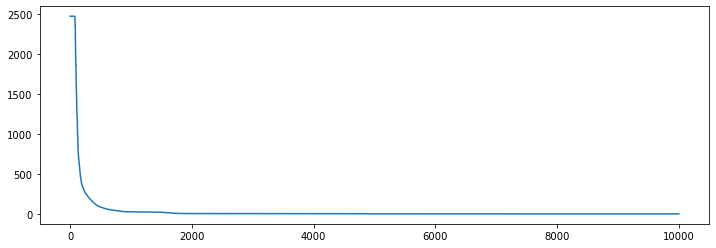

In [104]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [105]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=200, 
    K=0.5, 
    radius=(-600, 600), 
    number_of_iterations=10000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 13.853315606593634 
Best x: [ 2.09883515e-02 -1.02429019e-01 -3.80269806e-02 -4.48893027e-02
 -5.14966609e-03 -1.18324296e-01  5.66461242e-01 -3.33439251e-01
  1.11727781e+00 -2.61145746e-01 -7.89177686e-02 -1.03961575e+02
  7.38539907e-02  6.29497766e-02  1.62282029e-01 -1.16283131e-02
 -1.04962738e-01 -1.92526528e+00 -8.89042354e-02  3.64883062e-03
  4.81778268e-01 -3.62782271e-02 -3.32371187e-02 -8.99228423e-02
 -5.12849150e+00  1.61055028e-01 -6.90825026e-02  8.77145634e-02
  1.42282652e-02 -4.37866781e-02 -1.29148267e+00 -1.90513405e-03
 -7.61067629e-04  9.89802166e-02  2.14370225e-01  5.57279496e+00
 -2.92884557e-01 -2.86034060e-02  9.07879085e-02  1.89349234e+02
 -2.75956978e-01 -1.74191133e-01  2.82389597e-03  5.62475574e-01
  6.83334177e-02  2.03209833e+00 -8.42170674e-02 -1.64203395e-01
 -6.28407387e+01 -9.16395300e-03 -5.29394812e-01 -1.10716155e-01
 -4.94853210e+00 -1.50166036e-01  1.10265730e-02  5.16974872e-01
 -1.40884000e+01 -5.05171594e-02  1.14220

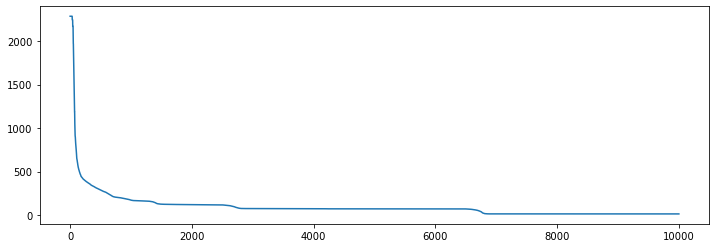

In [106]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [107]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=200, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=10000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 0.25634052587851486 
Best x: [ 3.13997048e+00  4.42992354e+00  5.43478307e+00 -3.84728461e-03
  1.16527794e-04 -1.99843531e-03 -1.54243747e-03 -8.18128749e-02
  7.47554049e-04  3.45557095e-04 -9.25283394e-03  2.57675178e-02
  2.85537698e-03  3.87706806e-03 -2.00024325e-01 -9.58993561e-03
  1.67165581e-02 -6.63174708e-02  1.25808600e-02 -2.28393474e-03
  1.86571161e-03  7.46168140e-05  9.28580044e-03 -6.40485220e-03
 -2.62333534e-01  1.72399034e+00  2.35039363e-03  1.37503619e-03
 -1.66264491e+01 -1.59384228e-03  2.59048286e-02  8.65381212e-03
 -2.60275109e-04  9.40385737e-03  2.12433818e-01  1.96739642e-01
  1.75501076e-02 -8.63550499e-03 -1.30362827e-02  1.75369035e-03
  5.79053689e-03 -4.94661517e-03  6.52500553e-03 -4.89195727e-02
  1.09425995e-02  2.75728041e-02 -2.66621528e-02  2.35540544e+00
  9.10375875e-03  5.10712200e-03  4.12699727e-03  3.84843960e-01
 -8.03626007e-03  2.53647876e-01 -2.15017883e-02  1.11045326e-02
 -1.17856329e-02  7.78531698e-04 -9.7806

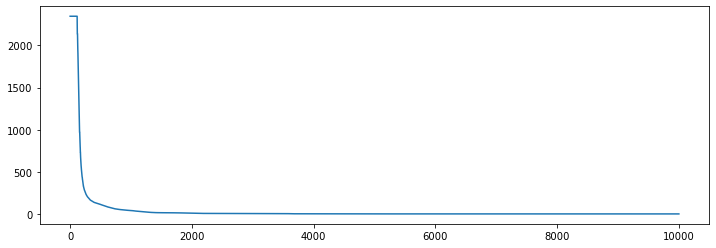

In [108]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [111]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=300, 
    children_size=600, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=10000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 16.770340369009457 
Best x: [ 3.13423081e+00 -4.42741432e+00  5.14852930e-03 -1.47916888e-02
  1.45500945e-02 -2.02550571e-01  8.22974946e+00 -2.31271164e-02
  1.22800902e-02 -8.46194794e-01  1.09849404e+01  2.09845629e-02
  7.98792811e-03  3.24575873e-02 -1.20904809e-02  2.16429368e-02
  1.03796086e-02  6.44177895e-03  2.34421292e-02  3.41960592e-01
 -3.72186286e-02 -4.70919186e-02  1.49844100e+01 -3.70893905e-02
  4.60047152e-03  1.71781335e-01 -1.48765156e-02 -7.62159461e-03
 -1.81628119e-02 -1.26860038e-02 -2.98081053e-02  3.38856566e-02
 -3.81729361e-02  1.62295417e-03 -8.85646598e-02  2.50649328e+02
  3.03723249e-01  1.01503705e-02  1.11881245e-02 -4.27423364e-01
  2.04334697e-02  1.34723225e-02  1.03401793e-02 -5.00695839e-02
 -1.25399855e-03  5.09005799e-02 -1.57936060e+01  2.23158086e-02
 -6.06491671e-03  4.53370482e-02  2.94516652e-01 -3.65128935e-02
  3.06339861e-02 -4.58052736e-01 -3.68403657e-03  1.36624389e-02
  4.76885672e-02  2.77605501e-02  1.49452

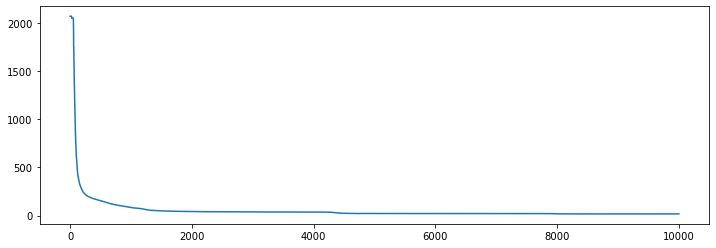

In [112]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [113]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=1000, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=10000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 2.3859286436965985 
Best x: [-3.14001250e+00  2.82397288e-05  6.77567320e-04  2.42763523e-04
 -3.76620927e-04 -5.64429602e-05 -8.28197295e+00  5.72563380e-05
  2.09044394e-04  2.50952607e-04  2.06236306e-03  1.44321764e-03
 -2.06939502e-04 -1.89640812e-04 -1.88332416e-04  3.31910704e-03
  2.30975875e-02 -1.67870401e-04 -1.53343283e-05  3.08423586e-04
  1.97263270e-04  6.02221429e-04  4.66184019e-04 -7.58983910e-03
  4.98371425e-05 -9.81924527e-05  9.66264292e+01 -1.95919476e-04
 -5.00708246e-03  6.89213443e-04 -9.42919796e-03 -2.73625608e-04
 -3.47404580e-02  1.50217487e-02 -1.54271333e-03  8.60981254e-04
 -1.01346730e-04  2.01064047e-04 -9.84377515e-03 -2.94523401e-03
 -6.26695091e-03 -4.18017265e-04 -1.57791009e-03  2.46116548e-03
 -2.16276129e-03 -8.38796861e-06  2.23688648e-04 -4.40053101e-03
 -7.13197494e-04 -3.53370524e-04  9.75001798e-05  2.20319107e-03
 -1.37467524e-04  1.48200802e-04 -3.48420566e-03 -1.33291139e-04
  4.00063712e-04 -3.11263337e-04  5.19367

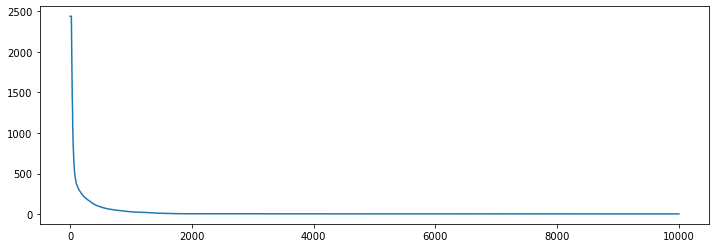

In [114]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [115]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=300, 
    children_size=600, 
    K=0.6, 
    radius=(-600, 600), 
    number_of_iterations=5000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 4.198871622000577 
Best x: [-6.02099643e+00  2.89074430e-01  1.37687732e-01 -1.53010083e+00
 -3.40479937e-01  6.44821047e-01 -4.38283323e-01  1.00100714e-01
  4.57686748e-02  8.93373863e-01  1.86149774e+00  5.47509166e-01
 -5.85548353e-02  1.69437489e+00 -3.93372746e-01  2.30491413e+00
 -3.75599462e-01  4.70086966e-02 -4.22267584e-01 -1.83481079e+00
 -6.01259946e-01 -3.94898080e-01  4.95963796e+00  1.53409100e+00
 -4.26357282e-02  9.68433442e-01  8.37176348e-02  1.17684064e-01
  2.54461930e-01  2.16243898e-01 -4.91646534e-01 -2.72759227e-01
 -6.20556911e-01  1.93986265e-01 -5.94071495e-01 -1.37535126e-01
  8.47667859e-01  2.23111997e+00 -1.58481155e-01  3.58153599e-02
  7.77254608e+00 -3.14444561e-01  1.30645573e-02 -8.25959272e-01
  4.54278896e-02  1.21199649e-01 -3.93149355e-01 -4.65445375e-01
 -2.96241471e-01  1.36170448e+00 -1.19551749e-02 -2.27682854e-01
  1.06098288e+00 -7.61305977e-01 -1.09697993e+02 -9.71244456e-01
 -6.10116796e-02  7.87265694e-01 -1.855043

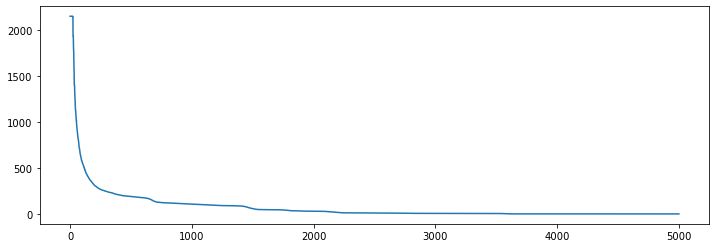

In [116]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()

In [118]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=300, 
    children_size=300, 
    K=0.4, 
    radius=(-600, 600), 
    number_of_iterations=5000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 2.149650223646431 
Best x: [-1.86700879e+00 -1.78702288e+00  3.86174428e+00 -8.65669440e+00
 -2.47077907e-01  4.06977148e+00 -3.39830503e-01 -1.76460852e-01
  5.22393589e-01  8.18287765e-01 -3.72976939e-01  4.23266862e-01
  5.91395576e+00  1.71472855e+00  3.68026763e+00 -4.60445362e+01
 -7.52941865e-01  2.25112438e+00 -7.19122954e-02 -3.35911274e+01
 -3.10176736e+00  3.54026737e-01  5.56232502e+00  3.13114541e-01
  3.69350833e-02  4.81212698e-01 -1.39341426e+00 -6.51776207e-02
  8.29201017e-01 -7.37566202e-01 -7.43321882e-01  1.33632034e+00
 -3.55489292e-01 -1.91972140e+00  1.08949682e+00  2.42808068e+00
  2.09731400e+00  1.82952542e+01  2.07253962e+00 -2.01259361e-02
  2.07123464e+00 -7.91228099e-01  5.69718114e-02  1.93251974e+00
  6.89692790e-01  1.53586998e+00  9.47737286e+00  3.56768693e-01
 -1.49820924e+00  4.82069917e-01 -2.38257040e+00 -1.21856994e+00
  2.58316829e+00  6.09578991e-01  1.71316410e-01  6.37689019e+00
 -3.72245212e+00 -6.88114843e-01 -1.395055

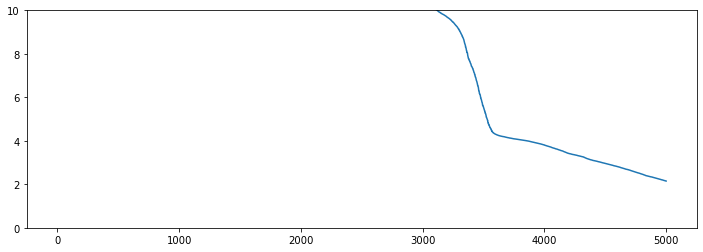

In [119]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.ylim(0, 10)
plt.show()

In [120]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=100, 
    K=0.4, 
    radius=(-600, 600), 
    number_of_iterations=20000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 2.709699728401973 
Best x: [ 1.38135375e-02 -1.19439514e-03 -8.74966736e-02 -8.08382147e-04
  5.17172267e-03  1.54862186e-03 -1.13590433e-02  4.17305730e-03
 -3.60741938e-03  1.05249178e-02  1.83678307e+01  8.38818758e-03
 -1.46317599e-02 -3.09141983e+00 -4.50041139e+00  2.42379902e-03
  3.71852392e-03 -1.68878615e-03  2.06721652e-03  2.83083195e-02
 -1.75339030e-01 -1.27429319e-03  2.71167597e-01  2.89849238e-01
 -1.69653457e-01 -3.01692447e-02 -3.95766826e+00  2.54743578e-03
  5.21659662e-03  8.49621173e-02 -4.53524489e-03 -7.38679712e-04
 -6.38079701e-03  1.64395552e-01 -6.34686568e-02 -3.00975301e-02
 -1.28981291e-03  9.71467820e-02 -8.22714359e-03 -1.25616804e-02
 -3.26855165e-02 -1.62338698e-01  6.21485710e-03 -3.16275664e-04
  9.10685466e-02  1.94036691e+01 -1.20743242e-01  3.74874514e-03
  2.96394552e-02 -4.04083501e-03  4.39908510e-01  2.40678818e+00
 -1.24304471e-03 -2.87139417e-01  1.85361863e-03  5.82602612e-03
 -9.37017424e-02  2.15815525e+00 -5.330327

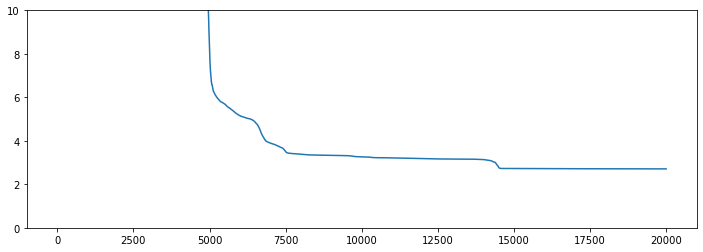

In [121]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.ylim(0, 10)
plt.show()

In [124]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=200, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=20000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 0.2712538684624346 
Best x: [-3.14097834e+00  4.57568172e-05 -2.39196817e-04  2.72040699e-04
  5.83772214e-03 -3.54413986e-04  1.14616108e-03 -1.37450812e-02
  2.18636085e-03  1.01152087e-03 -9.02534436e-04 -4.75772703e-04
  1.45171804e-03  7.20544389e-04  1.43254575e-03 -6.39903923e-05
  4.40926290e-03  2.32530907e-04 -3.05428750e-04  1.30240243e-01
 -1.90812531e-02 -1.43564488e-03 -2.91333211e-03 -1.09250054e-03
  1.12681448e-03  4.11344943e-04  2.08738156e-02 -6.21723139e-04
  8.89675072e-03 -3.07610815e-02  1.22184623e-03  1.60414047e-03
 -8.87600814e-04 -3.05096088e-03  8.64701795e-04  1.66649067e-03
 -1.39312710e-03  1.88010401e-03 -8.32794002e-01  5.30929207e-04
  6.91194840e-02  1.92266799e-03  5.17303972e-03  8.59747228e-04
  5.02869378e-04  5.75843699e-04 -2.35425014e-02 -1.27668436e-02
 -1.56501486e-02 -1.14796002e-01 -1.12618712e-03 -8.74434317e-01
 -4.38124726e-03 -9.62272457e-03 -4.59070847e-03 -3.02740648e-03
 -3.25023253e-02  1.00284859e-03 -1.08594

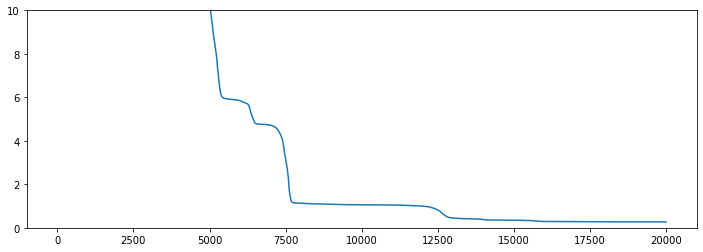

In [125]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.ylim(0, 10)
plt.show()

In [130]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=200, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=40000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 0.11656644860568122 
Best x: [-3.13947044e+00  5.63938931e-04  2.63975712e-02  1.75147063e-03
  2.02413597e-04  6.78223522e-03 -7.09947402e-04 -5.85006660e-03
  6.03731096e-04 -1.06912395e-03  1.46932426e-03  6.94257195e-05
  8.96770712e-04  6.63580925e-04  3.09406039e-03  2.22968515e-02
  2.24402364e-03  5.76532804e-04  1.59226652e-03  1.18972488e-04
 -2.30102925e-03  1.31242008e-04  7.59380199e-04  2.02217282e-02
 -1.19342248e-03  3.36502204e-02  1.68893749e-02 -2.45675313e-03
 -2.42474533e-04 -1.69416780e+01 -1.54076540e-02  1.57076952e-03
 -4.49642841e-02 -1.44193428e-02 -2.05861488e-02  5.07871946e-06
  2.14983024e-02 -2.53989131e-02  1.29718585e-03  1.90810322e-03
  4.98949239e-04 -6.78634055e-03  2.85167156e-03 -1.42118689e-02
  1.17349590e-01  2.39638514e-02 -2.38902114e-03  1.51331286e-04
 -1.37921809e-03  1.82089285e-04 -2.60711243e-03 -1.93278796e-02
 -1.21458851e-02  1.12318347e-02  2.16624888e-03 -9.76886754e-03
 -2.36423228e-02  5.58892131e-03  2.0482

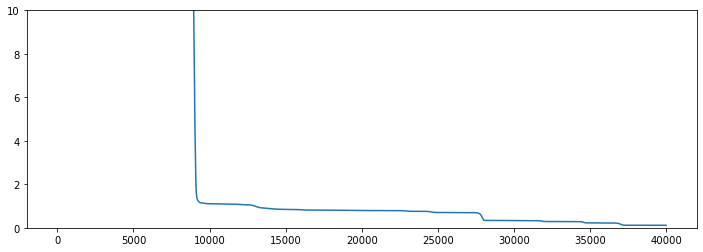

In [131]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.ylim(0, 10)
plt.show()

In [134]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=200, 
    children_size=400, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=20000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda)

Minimum value found: 2.076476428301196 
Best x: [-3.13991165e+00 -4.43821956e+00 -5.43264593e+00 -8.22902266e-05
  4.61703263e-05 -9.49063104e-04  4.43529692e-05  1.86201866e-04
 -3.75197242e+01 -1.97633004e+01 -7.82870158e-05  1.22567540e-04
 -7.87498640e+01  1.43860290e-04  7.44325699e-05  4.50511375e-03
  2.10611772e-03  3.57319400e-04 -1.73916322e-03  4.50405161e-05
 -9.47281449e-04  2.93895176e-03  5.74915140e-05  2.71870990e-05
 -5.96266989e-04 -1.12473784e-04  1.00501593e-04 -1.56083424e-05
  5.67220698e-03 -2.89466151e-04  1.59943281e-04 -1.30486743e-02
  1.72376542e-03  1.58818675e-02 -4.02594144e-04 -2.66972896e-03
 -3.70071674e-04  1.53396788e-04  1.44416583e-02  7.03019526e-05
  3.78126605e-04 -9.33455044e-04 -4.90410867e-04 -1.12736633e-04
  2.22208295e-03  1.21813771e-04 -1.53460245e-04  8.21544745e-05
 -9.96162654e-05 -2.29619431e-02 -1.63947130e-03 -9.71451171e-03
  1.50126582e-04  8.27481249e-05 -1.04906548e-02 -2.62464670e-04
  5.10048395e-04 -4.45227696e-02  2.582771

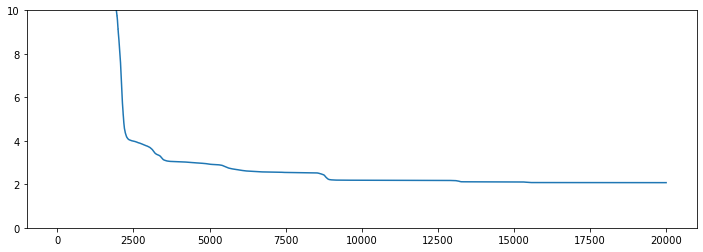

In [135]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.ylim(0, 10)
plt.show()

In [63]:
best_chromosome, hist_of_best_objectives = ES(
    objective_function=griewank, 
    d=100, 
    population_size=100, 
    children_size=200, 
    K=0.35, 
    radius=(-600, 600), 
    number_of_iterations=40000, 
    parent_selection=roulette_selection, 
    replacement=lambda_replacement)

Minimum value found: 0.9099171085205332 
Best x: [-3.13110550e+00 -3.27295682e-05 -4.63347155e-04 -1.61204817e-02
 -1.24400879e-05  2.72048225e-03 -8.12173597e+00  4.81514928e-04
  2.83406518e-05  6.96753369e-05  3.44052340e+00 -1.20824601e-03
 -1.23656993e-03 -9.83933794e-01  2.54655404e-05  2.50879589e-04
 -4.41056360e-05  3.94277038e-03  5.09403249e-03 -2.36636603e-04
 -6.51783976e-05  3.79276362e-05  3.05106464e-04  8.25046373e-03
 -1.58260650e-04  6.24366815e-04 -2.96188611e-04 -7.98596244e-03
  6.96033006e-01 -1.05631948e-04  2.99888741e-03  2.11825887e+00
  1.42649722e-05  7.18713962e-03 -3.55442227e-02 -1.62276237e-03
 -1.58917016e-01  1.11874102e-01 -6.48598356e-05  1.51627828e-02
  1.14697556e-04 -9.67033267e-07  1.59791328e-04 -2.19119714e+00
  4.12216178e-03  9.27317065e-01  9.65823761e-04  1.32008121e-04
  1.55725480e-04  4.04003989e-03 -5.01422754e+00  5.16969471e-05
 -3.98547976e+00 -2.42081208e-03 -2.90567680e-02  3.27086464e-02
 -7.63983753e-03  3.45357138e-01 -1.71746

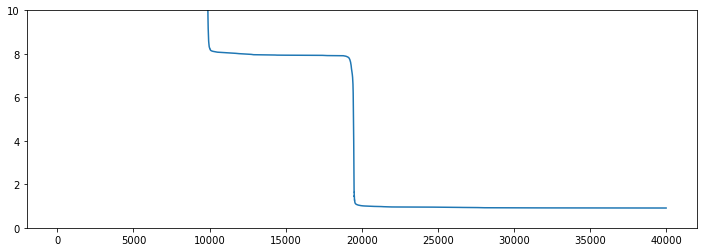

In [64]:
print("Minimum value found:", griewank(best_chromosome), "\nBest x:", best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.ylim(0, 10)
plt.show()

In [11]:
def ES_start_sigma(objective_function=lambda x: (x ** 2).sum(axis=0), d=10, population_size=400, children_size=400, K=0.5, 
       radius=(0, 1), number_of_iterations=100, parent_selection=roulette_selection, replacement=mi_plus_lambda,
        sigma=0.5):
    
    tau = K/np.sqrt(2*d)
    tau0 = K/np.sqrt(2*np.sqrt(d))
    
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, d))
    hist_of_best_objectives = np.zeros(number_of_iterations)
    
    current_population = np.zeros((population_size, d), dtype=np.float64)
    current_sigmas = np.zeros((population_size, d), dtype=np.float64)
    objective_values = np.zeros(population_size)
    
# set starting random population and sigmas
    current_population = np.random.uniform(low=radius[0], high=radius[1], size=(population_size, d))
#     print("\nx:", current_population)
    current_sigmas = np.ones((population_size, d)) * sigma
#     print("\nsigmas:", current_sigmas)
    
# evaluating the objective function on the current population
    for i in range(population_size):
        objective_values[i] = objective_function(current_population[i, :])
#     print("\nvalues:", objective_values)
    
    for t in range(number_of_iterations):
# parent selection
        children_population, children_sigmas = parent_selection(current_population, current_sigmas, 
                                                                objective_values, population_size, children_size)
        
# mutating children
        for i in range(children_size):
            epsilon0 = np.random.normal(loc=0.0, scale=tau0)
            children_sigmas[i, :] = children_sigmas[i, :] * np.exp(np.random.normal(loc=0.0, scale=tau, size=d) + epsilon0)
            children_population[i, :] = children_population[i, :] + np.random.normal(loc=0.0, scale=children_sigmas[i])
        
        np.clip(children_population, radius[0], radius[1], out=children_population)
        
# evaluating the objective function on the children
        children_objective_values = np.zeros(children_size)
        for i in range(children_size):
            children_objective_values[i] = objective_function(children_population[i, :])
        
# replacing the current population by given replacement
        current_population, current_sigmas, objective_values = replacement(current_population, children_population, 
                    current_sigmas, children_sigmas, objective_values, children_objective_values, population_size)
        
# recording some statistics
        hist_of_best_objectives[t] = objective_values[0]
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
    return best_chromosome, hist_of_best_objectives

# Sphere

In [13]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=sphere, 
    d=100, 
    population_size=500, 
    children_size=1000, 
    K=0.5, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.5)

Minimum value found: 0.4218317502692176


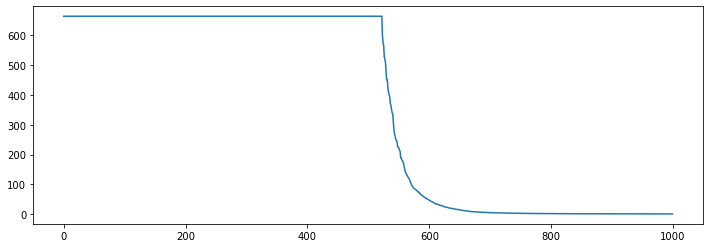

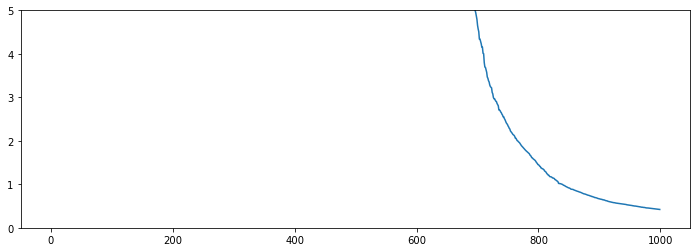

In [14]:
print("Minimum value found:", sphere(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 5)
plt.show()

# Shwefel

In [18]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.6, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.5)

Minimum value found: 19121.28512101714


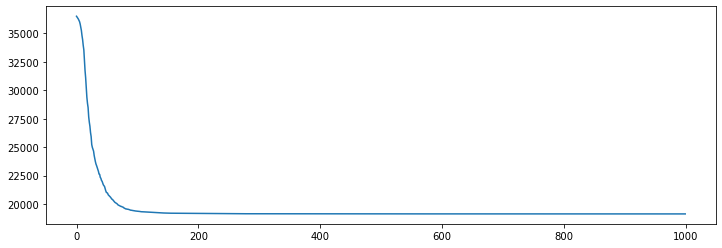

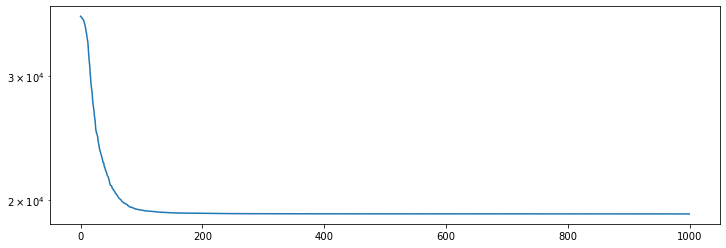

In [21]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [22]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.4, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.5)

Minimum value found: 15311.611231708077


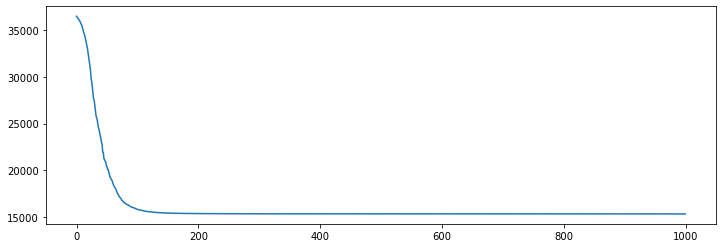

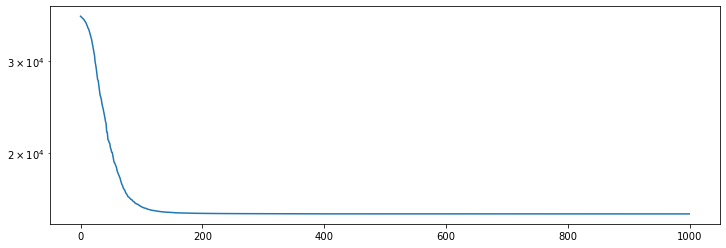

In [23]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [26]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.4, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.1)

Minimum value found: 17679.576185227863


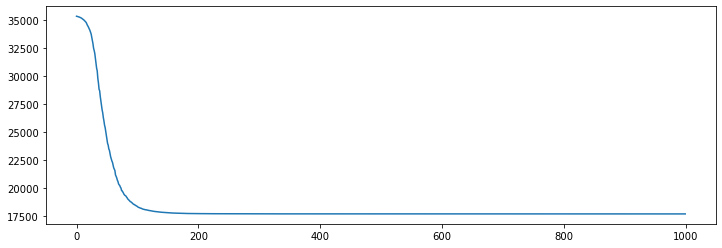

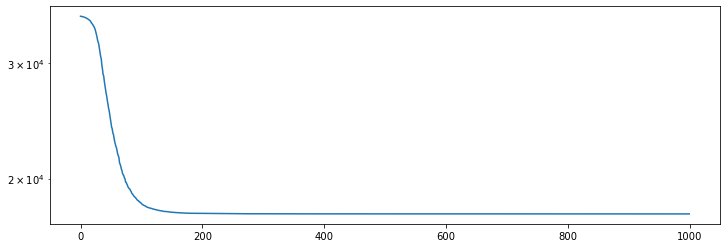

In [27]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [28]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.6, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.1)

Minimum value found: 18927.902253769298


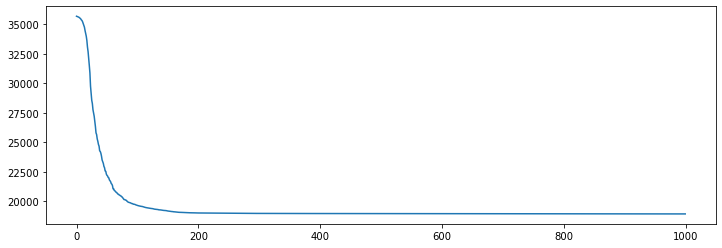

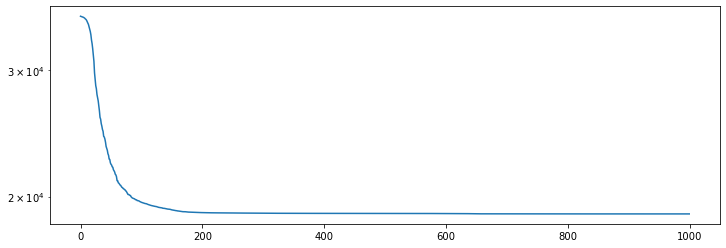

In [31]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [32]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.6, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=3.14)

Minimum value found: 16983.721898237098


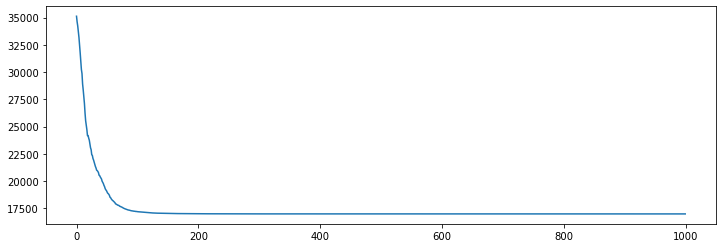

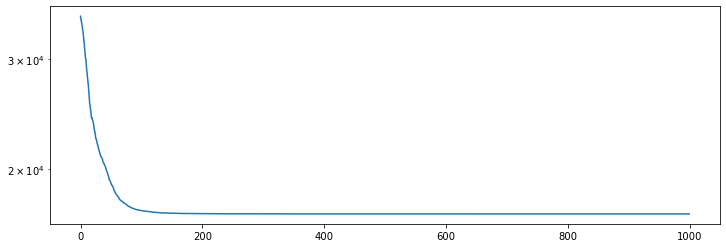

In [36]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [37]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.6, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=50)

Minimum value found: 16528.345477563013 [ 420.97871468  -25.89926865  420.95548915  420.95072924   65.39234619
  203.67422888   65.31826161  420.51831835  203.80437458   65.57191835
 -124.86133491 -302.51657568 -124.81092374 -302.51741348  420.98511087
 -302.53596043 -125.10481309 -124.82409645 -302.53996694  203.79628002
  -25.86599823  203.83189644   65.52781072 -124.805195    420.98579225
  -25.87252852  420.95327599  203.87088511  203.81138618 -302.5382619
 -124.83771089  420.96017816  203.82659879  420.93442548  203.80758035
  420.96932249 -500.          203.53494919   65.54215311 -124.83288745
  420.95749384   65.54072748  420.96415071  420.96373986  203.85352167
  420.99153685  420.96100572 -302.54079403  421.03813117 -302.5220741
  420.97695652 -500.         -302.58560949  420.96701596 -124.81393348
  203.84950045  420.948092    203.82303793 -302.52382646 -302.5354525
  420.7695008  -500.          421.00957864  203.81083542  420.88281292
  420.94059442  203.81585678 -124.829068

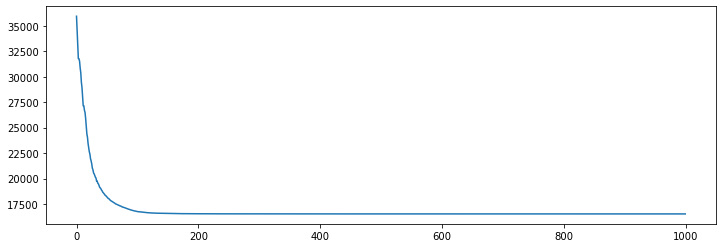

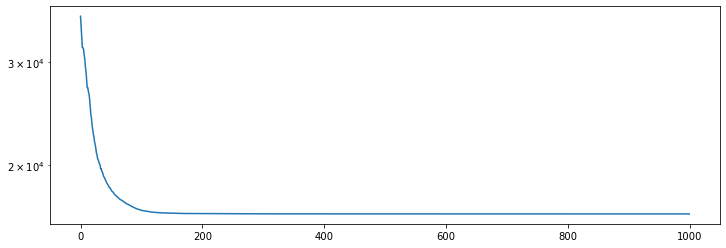

In [39]:
print("Minimum value found:", schwefel(best_chromosome),best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [40]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.4, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=50)

Minimum value found: 16217.518612320666 [ -25.89645911  420.63562601  203.7681571   420.98587846  203.74149586
 -500.          420.95813144  420.89370013  203.92058813  420.89393853
  420.92316851  420.96106873 -302.49895593 -302.34254367  203.77593696
 -302.53751308 -124.82060638  420.91589527   65.67454     421.13969597
   65.53116734 -124.78414224 -302.50286779   65.58297321 -302.49686178
 -500.         -124.7151116  -124.94951991  420.92803622  420.25575535
 -302.56580728    5.24495228  420.98858709  420.96967787  420.88303108
 -124.8334873   203.82293394 -302.36400979 -500.          203.7725185
 -302.3898605  -302.55362972  421.02075231 -302.49693316  420.91643171
  420.98642313 -302.68631624 -125.08210065  203.86620444   65.49789891
  203.76271558 -302.55997405   65.53786836 -124.74055908  420.98045724
  203.72158648 -124.96295827   65.52395746 -124.89961047  421.10871059
 -302.56598973  203.85325648 -500.          420.89913622  420.89377406
 -302.55776992  203.8522049  -302.5611

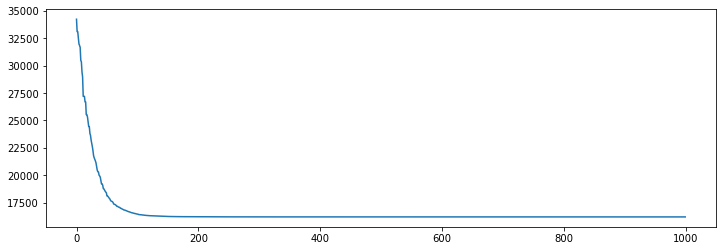

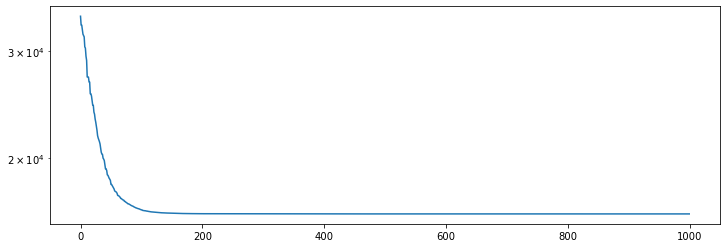

In [41]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [42]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.8, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=50)

Minimum value found: 15892.372574099776


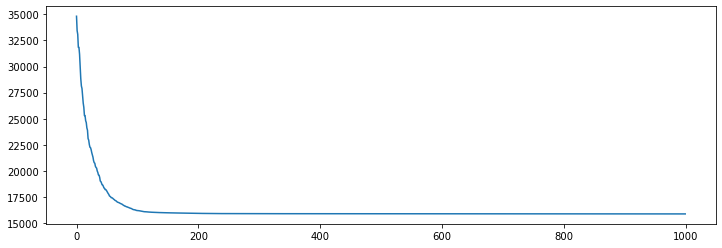

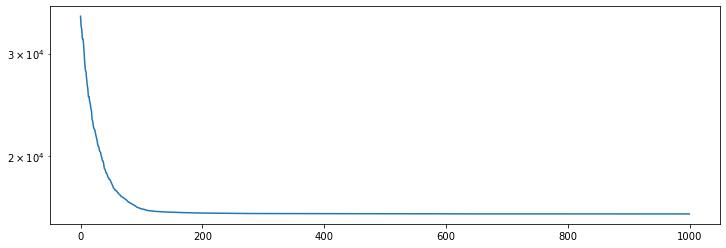

In [43]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [44]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=1.5, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=50)

Minimum value found: 18565.376788973415 [-302.52486884 -302.10580583  420.61175086   65.57133192 -499.99953184
 -124.86075551  -25.932061    421.05684536   65.55216768  421.43801902
 -499.99992338 -302.5188372   203.78758513  420.61403394 -302.53185431
 -124.93401122  201.48114677   66.81079581  420.98692176   65.26804481
  -25.92616841  422.21475672 -129.62709817  420.96203044   -6.47671273
  203.79693766  -25.93272132  421.50910081   65.52627443  202.94018961
 -302.49182276  -27.32038721  420.99854477  203.81764914  421.08719052
  419.63671017  203.81361996 -301.01277155  420.97291816 -499.9994078
  204.09166858  203.78527232 -124.79522059 -302.91735937 -499.99946626
 -302.30513571  420.96985107  203.79360832  -25.86156221  419.83663476
 -124.82929266    5.21925077  421.03217239 -124.93287932  420.96812815
 -302.07206726 -302.56970966 -499.99998707  203.7732307    65.59114422
 -302.57376017  205.20581478 -302.52815678 -302.31113922  421.15718647
  421.28901394  203.8963211   420.9487

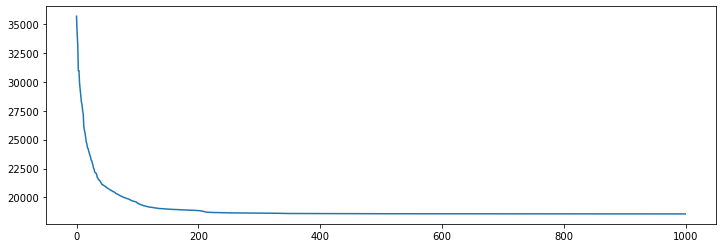

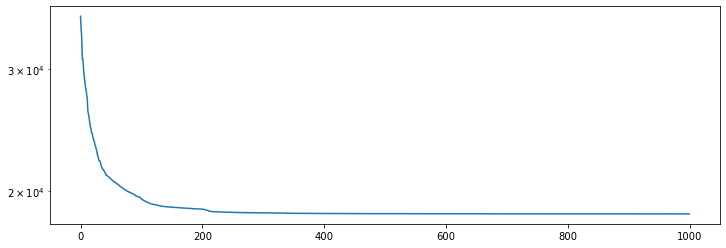

In [46]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [47]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=1.5, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=5)

Minimum value found: 15444.08768057108


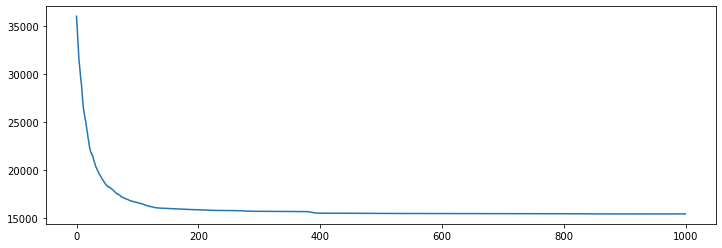

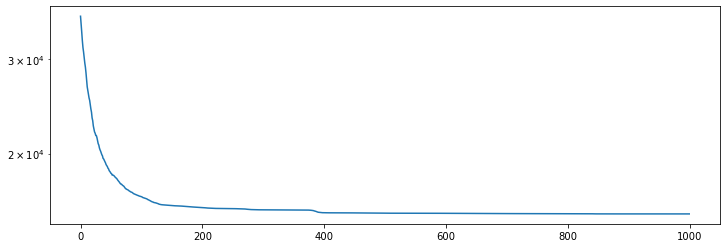

In [48]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [55]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.1, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=10)

Minimum value found: 16993.470338009753 [ 204.43828658 -302.54078531 -125.15971806  421.00182536  -25.6055774
  421.48591696   66.02939166   65.44979243  202.87171317  203.04282559
  421.26230568 -500.         -302.74386201  203.23411577 -301.70052958
  -26.53949419  202.75124999  -25.21220331 -303.62845275  421.2033981
  -25.85122105  204.2993412   202.7530253   421.91989639 -303.33007875
 -302.42277384 -301.27340026   66.25805368 -302.40736075  420.99193676
  420.76553104 -302.1659474  -303.12472311    5.08953106 -500.
 -125.36956873  204.08419257  420.85113861 -301.89042582 -302.12672296
  420.27669638  420.66077543  421.29902273 -303.29591508  203.75054459
  421.20562267  421.92146688  420.19836913  203.17912287 -124.53864728
  204.53974622  421.25182533 -302.72603118  420.26133668 -302.97395307
 -301.84019453 -123.88960412 -124.48241234  203.54777135 -500.
  419.77982606   65.8874197    65.63999358 -301.98426352  421.27199654
  421.31835138   65.27444858 -500.         -302.7198250

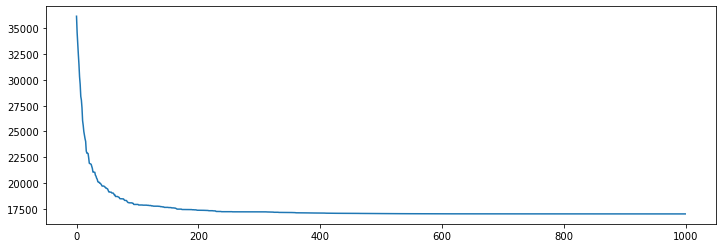

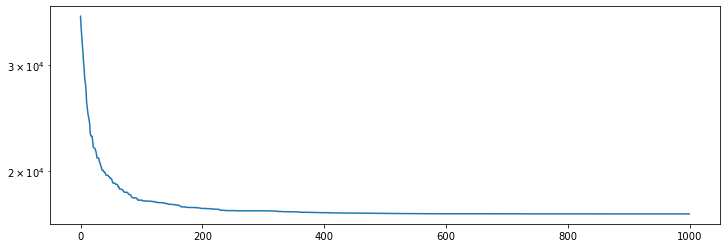

In [57]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [58]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.3, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=50)

Minimum value found: 16975.458850793417 [ 420.36602457  -26.48557859  204.22621028  420.90757538  420.60793365
  420.91180695  420.95926442  421.67047223    5.05378544 -301.65894987
  203.83581047 -302.53595559 -124.72456166  421.01165697 -302.5695771
 -124.89925445 -301.01116053  421.05820429  420.7969106  -125.33860891
 -302.432708   -302.90912455  421.6350276   421.29998182  420.06653658
 -302.11190712 -302.45706857 -301.65508378  421.62974089    5.23868764
  420.57508803 -302.40226839 -124.69136526 -302.20426847 -500.
 -124.97572703  203.95096735  -26.05856176   65.76698577 -302.40256919
  420.87186427 -302.1521871  -125.02910522    4.92197932 -500.
 -302.53424634 -302.00448725 -124.40443581 -500.          420.82953269
 -125.3689598    65.47833268  420.57056882  420.82492059 -302.52715299
  -27.9996316  -302.71275659 -303.70441453  420.83406521  204.37164991
 -302.04678673 -303.32580711 -302.24508939 -500.         -124.68968394
  420.49827812 -302.94385965 -500.         -124.392828

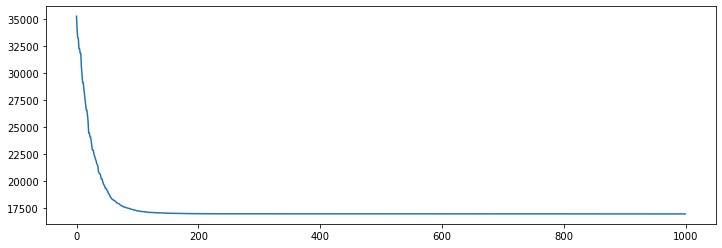

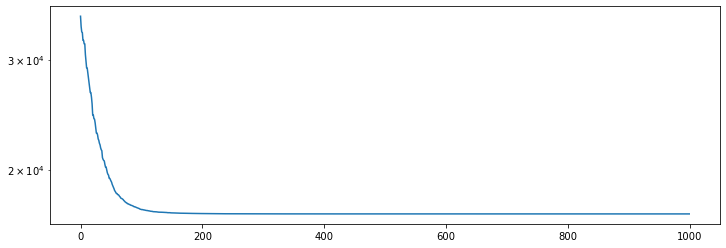

In [59]:
print("Minimum value found:", schwefel(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

In [66]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=schwefel, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=1.0, 
    radius=(-500, 500), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=50.0)

Minimum value found: 15904.882454652816


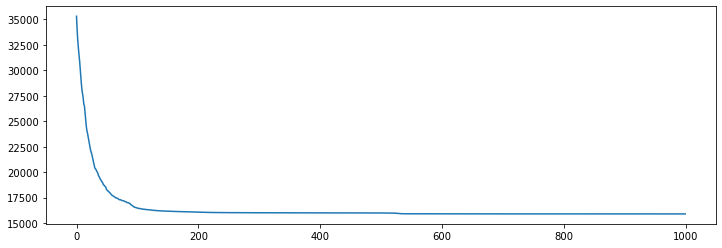

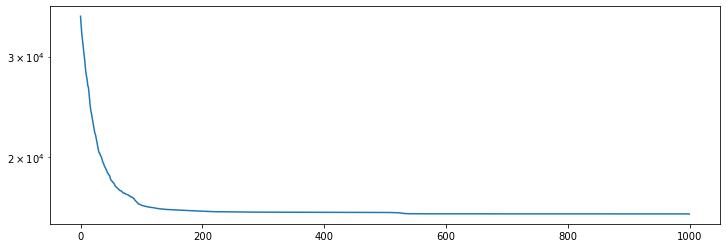

In [68]:
print("Minimum value found:", schwefel(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.yscale("log")
# plt.ylim(0, 1)
plt.show()

# Rastrigin

In [14]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=rastrigin, 
    d=100, 
    population_size=500, 
    children_size=4000, 
    K=0.5, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.5)

Minimum value found: 434.7948766425054


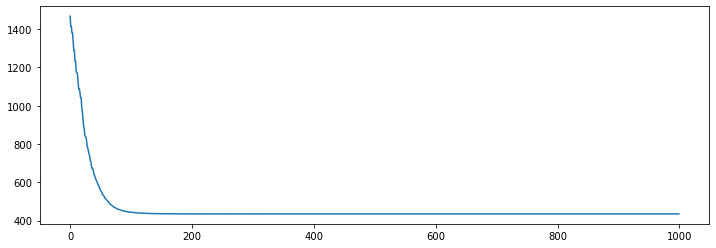

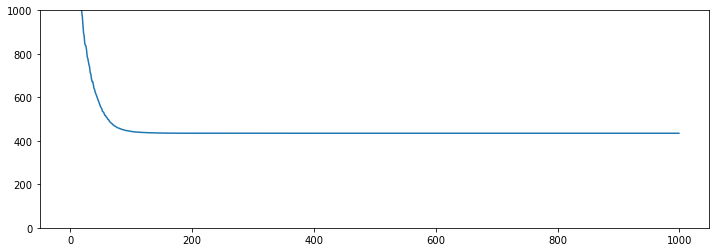

In [15]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [18]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.20, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=0.5)

Minimum value found: 401.96159701084184


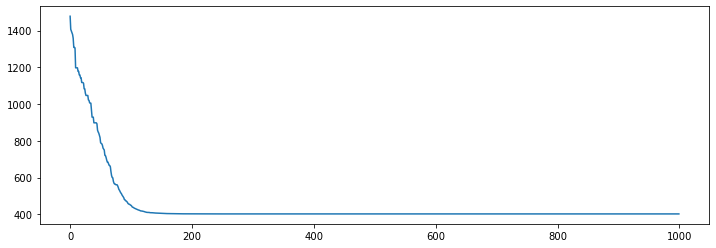

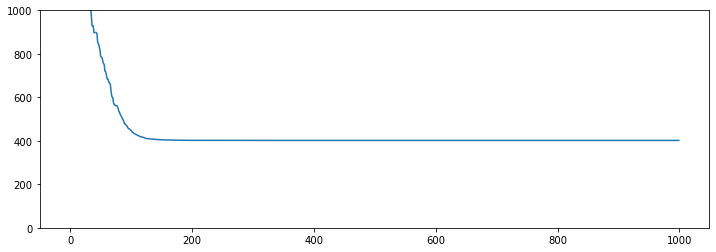

In [19]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [20]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.20, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=2.0)

Minimum value found: 242.76930212320462


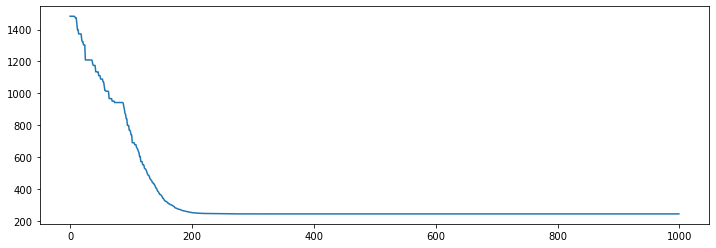

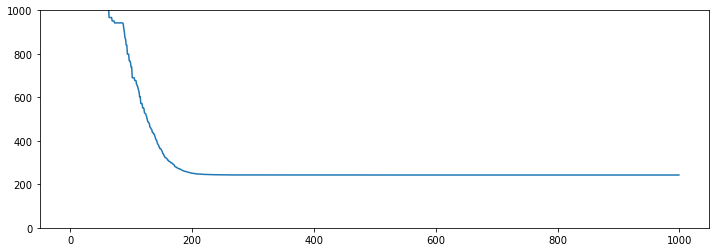

In [21]:
print("Minimum value found:", rastrigin(best_chromosome))
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(0, 1000)
plt.show()

In [27]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.15, 
    radius=(-5.12, 5.12), 
    number_of_iterations=1000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=2.0)

Minimum value found: 173.348943338014 [ 1.99801779e+00  2.68597647e-03  1.99448905e+00  2.80529555e-04
  4.97974464e+00 -1.65659968e-02 -9.92101892e-01  9.99395032e-01
  9.94027241e-01 -1.30901134e-02 -1.99874868e+00  6.46994289e-03
 -9.92910039e-01  6.67664459e-03  1.12060206e-02 -1.56330813e-03
 -1.00533725e+00 -1.99790287e+00  3.47824831e-03  9.88503793e-01
  9.83197615e-01  2.00075592e+00  1.32697836e-03  9.98188168e-01
  1.98922806e+00  9.97201374e-01  9.90691427e-01  4.82306274e-03
 -2.59503129e-03  9.98615022e-01 -8.68921557e-04 -5.92884031e-03
  1.98883377e+00  9.91087721e-01 -9.97030866e-01 -7.26077235e-04
  9.89851585e-01  1.00758653e+00 -4.67827052e-03 -1.98317692e+00
  4.78616141e-03 -1.97711668e+00 -2.99050753e+00  1.98643175e+00
 -1.00209519e+00  9.93946480e-01  5.76479095e-03 -9.83063193e-01
 -7.37805676e-03  1.06943412e-02 -9.89026965e-01  1.99754286e+00
  9.95677274e-01 -1.00727153e+00  1.00675709e+00  2.90478720e-03
 -9.90971032e-01  1.99083235e+00  9.93330055e-01  2.

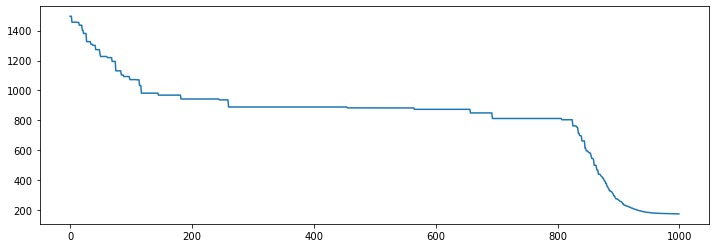

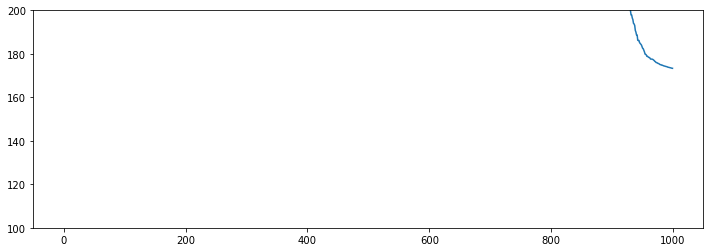

In [30]:
print("Minimum value found:", rastrigin(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(100, 200)
plt.show()

In [31]:
best_chromosome, hist_of_best_objectives = ES_start_sigma(
    objective_function=rastrigin, 
    d=100, 
    population_size=1000, 
    children_size=8000, 
    K=0.15, 
    radius=(-5.12, 5.12), 
    number_of_iterations=2000, 
    parent_selection=roulette_selection, 
    replacement=mi_plus_lambda,
    sigma=2.0)

Minimum value found: 214.91060085091317 [ 1.98991224e+00  4.77615777e-09  9.94958637e-01 -9.94958639e-01
  2.10423916e-09  2.71110744e-09  1.98991224e+00  3.97978386e+00
 -1.98991224e+00 -9.94958636e-01 -1.98991224e+00  5.51993224e-09
  2.16901244e-09  9.94958632e-01  9.94958635e-01  2.98485570e+00
  1.98991224e+00 -9.94958638e-01 -1.98991224e+00  9.94958633e-01
 -9.94958638e-01 -1.98991223e+00  9.94958634e-01 -4.68929300e-10
  9.94958631e-01 -9.94958632e-01  1.98991223e+00 -2.21745459e-09
 -1.98991223e+00 -2.65913006e-09  9.94958639e-01  9.94958640e-01
  4.24012702e-09  9.94958641e-01  1.98991223e+00  9.94958632e-01
 -9.94958641e-01  2.42507731e-09 -9.94958635e-01 -1.98991223e+00
  9.94958637e-01  9.94958643e-01  3.78277322e-09  1.64292282e-09
  1.98991224e+00 -9.94958636e-01 -1.96106172e-09  9.94958633e-01
  9.94958639e-01 -3.97978386e+00 -1.20904139e-09 -1.98991224e+00
 -9.94958631e-01 -9.94958638e-01 -4.67222190e-09 -2.98485569e+00
  9.94958641e-01 -9.94958638e-01 -9.94958636e-01  

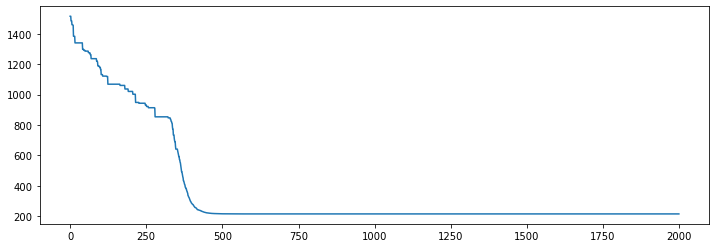

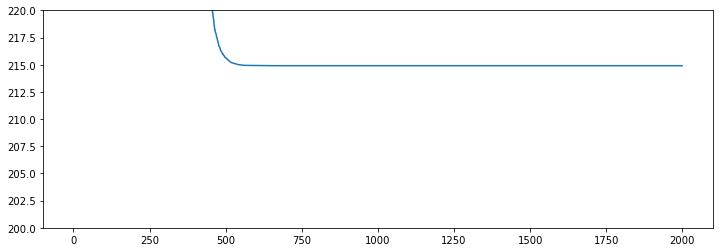

In [33]:
print("Minimum value found:", rastrigin(best_chromosome), best_chromosome)
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
plt.show()
plt.figure(figsize=(12,4))
plt.plot(hist_of_best_objectives)
# plt.yscale("log")
plt.ylim(200, 220)
plt.show()